In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
import joblib
from lightgbm import LGBMClassifier
import xgboost as xgb


# Functions

In [2]:
def load_df(input_path: str, sep: str = ";", decimal: str = ",") -> pd.DataFrame:
    """
    Load a DataFrame from a file.

    Args:
        input_path (str): The path to the input DataFrame file.
        sep (str, optional): The delimiter used in the input file (for CSV files). Defaults to ";".
        decimal (str, optional): The character recognized as a decimal point (for CSV files). Defaults to ",".

    Returns:
        DataFrame: The loaded DataFrame.

    Raises:
        ValueError: If the input file format is not 'csv' or 'pkl'.
    """
    import pandas as pd
    import os

    try:
        # Extract filename and extension
        _, in_extension = os.path.splitext(os.path.basename(input_path))

        # Read the dataframe
        if in_extension == ".csv":
            df = pd.read_csv(input_path, sep=sep, decimal=decimal)
        elif in_extension == ".pkl":
            df = pd.read_pickle(input_path)
        else:
            raise ValueError(
                f"Format {in_extension} not supported. Only 'csv' or 'pkl' are supported.")

        return df

    except Exception as e:
        raise e

### Outliers replacement

In [3]:
def detect_outliers(df, whiskers=1.5):
    """Detect outliers

    Args:
        df (DataFrame): Input data frame with numeric values only
        whiskers (float, optional): Threshold to compute the upper and lower bounds. Defaults to 1.5.

    Returns:
        outliers_info (dict): Dictionary containing columns with outliers and the number of entries with outliers
    """
    # Make sure the selected values are the numeric ones
    df_numeric = df.select_dtypes('number')
    # Compute the quantiles for each column
    quant = df_numeric.quantile(q=[0.75, 0.25])
    # Compute the IQR and the upper and lower bounds used to consider outliers
    iqr = quant.iloc[0] - quant.iloc[1]

    up_bound = quant.iloc[0] + (whiskers*iqr)
    low_bound = quant.iloc[1] - (whiskers*iqr)

    # Detect outliers
    outliers_mask = (df_numeric > up_bound) | (df_numeric < low_bound)
    outliers_count = outliers_mask.sum()

    # Get columns with outliers and the number of entries with outliers
    columns_with_outliers = outliers_count[outliers_count > 0].index.tolist()
    num_entries_with_outliers = outliers_count[outliers_count > 0].values.tolist(
    )

    # Create dictionary with outliers info
    outliers_info = list(zip(columns_with_outliers, num_entries_with_outliers))

    return outliers_info

In [4]:
def replace_outliers(df, whiskers=1.5):
    """Replace outliers with median value

    Args:
        df (_type_): Input data frame with numeric values only
        whiskers (float, optional): Threshold to compute the upper and lower bounds. Defaults to 1.5.

    Returns:
        Data Frame: With outliers replaced. 
    """
    # Make sure the selected values are the numeric ones
    df_numeric = df.select_dtypes('number')
    # Compute the quantiles for each column
    quant = df_numeric.quantile(q=[0.75, 0.25])
    # Compute the IQR and the upper and lower bounds used to consider outliers
    iqr = quant.iloc[0] - quant.iloc[1]

    up_bound = quant.iloc[0] + (whiskers*iqr)
    low_bound = quant.iloc[1] - (whiskers*iqr)

    # Replace values above upper bound with median
    df_numeric = df_numeric.apply(lambda x: x.mask(
        x > up_bound.loc[x.name], np.nan), axis=0)

    # Replace values below lower bound with median
    df_numeric = df_numeric.apply(lambda x: x.mask(
        x < low_bound.loc[x.name], np.nan), axis=0)
    
    # Replace the numeric columns in the data set
    df[df_numeric.columns] = df_numeric

    return df

### Missing values

In [5]:
def detect_missing_values(df, threshold=0.1):
    """Detect missing values and return columns to drop (if pass the threshold) and the ratio of the missing values.

    Args:
        df (DataFrame): Data Frame
        threshold (float, optional): Threshold to drop columns. Defaults to 0.1.

    Returns:
        tuple: Tuple containing columns to drop and their respective ratio of missing values
    """
    nrows = len(df)
    # Retrieves the columns with null values
    col_w_nulls = df.columns[df.isna().any()]
    # Ratio of null values
    null_ratio = df[col_w_nulls].isna().sum(
    ).sort_values(ascending=False) / nrows
    # Columns with null values greater than the threshold
    cols_to_drop = list(null_ratio.index[null_ratio > threshold])

    return cols_to_drop, null_ratio

In [6]:
def drop_and_impute_missing(df, cols_to_drop=[], set_type="train", imputer=None):
    """Drop columns based on a list of column names, and impute values based on the imputer passed (if any)
    and depending on if the df is the test or training set.

    Args:
        df (DataFrame): Data Frame
        cols_to_drop (list, optional): List of column names to drop. Defaults to [].
        imputer (object, optional): Imputer object to impute missing values. Defaults to None.
        set_type (str, optional): check if the df is the test or train set. Options: test, train.

    Returns:
        DataFrame: DataFrame after dropping columns and imputing missing values
    """
    if cols_to_drop:
        df.drop(columns=cols_to_drop, axis=1, inplace=True)

    if set_type.lower() == "train":
        if imputer is None:
            imputer = SimpleImputer(strategy="most_frequent")
        df[df.columns] = imputer.fit_transform(df)
        df[df.columns] = df[df.columns].infer_objects()
        # print(df.info())
        return imputer
    elif set_type.lower() == "test":
        if imputer is None:
            raise ValueError(
                "An imputer object is required for imputing missing values in the test set.")
        df[df.columns] = imputer.transform(df)
        df[df.columns] = df[df.columns].infer_objects()
        # print(df.info())
    else:
        raise ValueError(
            "Invalid set_type. Allowed options are 'train' or 'test'.")

    return

### Scaler

In [7]:
def my_scaler(df, set_type="train", scaler_chosen=None, scaler_type="robust"):
    """Scale a dataset with a passed/selected scaler type.

    Args:
        df (_type_): Dataset to scale.
        set_type (str, optional): Dataset type 'train' or 'test'. Defaults to "train".
        scaler_chosen (_type_, optional): Scaler object to use. Needed if set_type = test. Defaults to None.
        scaler_type (str, optional): Scaler type to be used. Needed for trainin datasets. Defaults to "robust".

    Returns:
        _type_: Dataframe scaled.
    """
    
    from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer

    scaler_dict = {"robust": RobustScaler(),
                   "standard": StandardScaler(),
                   "power": PowerTransformer()}

    if set_type.lower() == "train":
        if scaler_type is None:
            return ValueError("A valid scaler type has to be chosen. Valid scalers are: 'robust', 'standard' and 'power'")
        scaler_chosen = scaler_dict[scaler_type]
        array_scaled = scaler_chosen.fit_transform(df)
        df_scaled = pd.DataFrame(
            data=array_scaled, columns=scaler_chosen.get_feature_names_out())

    elif set_type.lower() == "test":
        if scaler_chosen is None:
            return ValueError("An scaler object has to be passed.")
        array_scaled = scaler_chosen.fit_transform(df)
        df_scaled = pd.DataFrame(
            data=array_scaled, columns=scaler_chosen.get_feature_names_out())
    
    df_scaled.index = df.index

    return df_scaled, scaler_chosen

# EDA

## Load dataset

In [8]:
data = pd.read_csv("dataset.csv", sep=";", decimal=",", low_memory=False)

# Copy of the dataframe to keep data untouched
df = data.copy(deep=True)

In [9]:
df.dtypes

rev_Mean       float64
mou_Mean       float64
totmrc_Mean    float64
da_Mean        float64
ovrmou_Mean    float64
                ...   
kid11_15        object
kid16_17        object
creditcd        object
eqpdays        float64
Customer_ID      int64
Length: 100, dtype: object

In [79]:
df.Customer_ID=df.Customer_ID.astype(str)

In [80]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [9]:
# Describe the numeric variables
df.describe(include=np.number)

rev_Mean      mou_Mean   totmrc_Mean       da_Mean   ovrmou_Mean   
count  99643.000000  99643.000000  99643.000000  99643.000000  99643.000000  \
mean      58.719985    513.559937     46.179136      0.888828     41.072247   
std       46.291677    525.168140     23.623489      2.177619     97.296150   
min       -6.167500      0.000000    -26.915000      0.000000      0.000000   
25%       33.260000    150.750000     30.000000      0.000000      0.000000   
50%       48.195000    355.500000     44.990000      0.247500      2.750000   
75%       70.750000    703.000000     59.990000      0.990000     42.000000   
max     3843.262500  12206.750000    409.990000    159.390000   4320.750000   

        ovrrev_Mean   vceovr_Mean   datovr_Mean     roam_Mean    change_mou   
count  99643.000000  99643.000000  99643.000000  99643.000000  99109.000000  \
mean      13.559560     13.295062      0.261318      1.286405    -13.933818   
std       30.500885     30.056089      3.126531     14.711374    276.087509   
min        0.000000      0.000000      0.000000      0.000000  -3875.000000   
25%        0.000000      0.000000      0.000000      0.000000    -87.000000   
50%        1.000000      0.682500      0.000000      0.000000     -6.250000   
75%       14.437500     14.025000      0.000000      0.235000     63.000000   
max     1102.400000    896.087500    423.540000   3685.200000  31219.250000   

       ...        models         truck            rv           lor   
count  ...  99999.000000  98268.000000  98268.000000  69810.000000  \
mean   ...      1.545825      0.188820      0.082580      6.177238   
std    ...      0.898395      0.391368      0.275248      4.735267   
min    ...      1.000000      0.000000      0.000000      0.000000   
25%    ...      1.000000      0.000000      0.000000      2.000000   
50%    ...      1.000000      0.000000      0.000000      5.000000   
75%    ...      2.000000      0.000000      0.000000      9.000000   
max    ...     16.000000      1.000000      1.000000     15.000000   

             adults        income      numbcars      forgntvl       eqpdays   
count  76981.000000  74564.000000  50634.000000  98268.000000  99999.000000  \
mean       2.530326      5.783112      1.567563      0.057974    391.932309   
std        1.452819      2.182132      0.625456      0.233696    256.482193   
min        1.000000      1.000000      1.000000      0.000000     -5.000000   
25%        1.000000      4.000000      1.000000      0.000000    212.000000   
50%        2.000000      6.000000      1.000000      0.000000    342.000000   
75%        3.000000      7.000000      2.000000      0.000000    530.000000   
max        6.000000      9.000000      3.000000      1.000000   1823.000000   

        Customer_ID  
count  1.000000e+05  
mean   1.050000e+06  
std    2.886766e+04  
min    1.000001e+06  
25%    1.025001e+06  
50%    1.050000e+06  
75%    1.075000e+06  
max    1.100000e+06  

[8 rows x 79 columns]

In [10]:
df.describe(include=np.object0)

new_cell crclscod asl_flag prizm_social_one                area   
count    100000   100000   100000            92612               99960  \
unique        3       54        2                5                  19   
top           U       AA        N                S  NEW YORK CITY AREA   
freq      66914    36509    86064            32097               11098   

       dualband refurb_new hnd_webcap ownrent dwlltype  ... infobase HHstatin   
count     99999      99999      89811   66294    68091  ...    77921    62077  \
unique        4          2          3       2        2  ...        2        6   
top           Y          N       WCMB       O        S  ...        M        C   
freq      72265      85593      75733   64284    48759  ...    77697    39124   

       dwllsize ethnic kid0_2 kid3_5 kid6_10 kid11_15 kid16_17 creditcd  
count     61692  98268  98268  98268   98268    98268    98268    98268  
unique       15     17      2      2       2        2        2        2  
top           A      N      U      U       U        U        U        Y  
freq      47205  33389  94256  93572   90195    89454    88304    67234  

[4 rows x 21 columns]

In [17]:
# Customer ID do not give additional information
df.drop(columns="Customer_ID", inplace=True)

In [84]:
df.head()

rev_Mean  mou_Mean  totmrc_Mean  da_Mean  ovrmou_Mean  ovrrev_Mean   
0   23.9975    219.25       22.500   0.2475         0.00          0.0  \
1   57.4925    482.75       37.425   0.2475        22.75          9.1   
2   16.9900     10.25       16.990   0.0000         0.00          0.0   
3   38.0000      7.50       38.000   0.0000         0.00          0.0   
4   55.2300    570.50       71.980   0.0000         0.00          0.0   

   vceovr_Mean  datovr_Mean  roam_Mean  change_mou  ...  dwllsize  forgntvl   
0          0.0          0.0        0.0     -157.25  ...         A       0.0  \
1          9.1          0.0        0.0      532.25  ...         A       0.0   
2          0.0          0.0        0.0       -4.25  ...         A       0.0   
3          0.0          0.0        0.0       -1.50  ...         D       0.0   
4          0.0          0.0        0.0       38.50  ...         O       0.0   

   ethnic  kid0_2  kid3_5  kid6_10  kid11_15  kid16_17  creditcd  eqpdays  
0       N       U       U        U         U         U         Y    361.0  
1       Z       U       U        U         U         U         Y    240.0  
2       N       U       Y        U         U         U         Y   1504.0  
3       U       Y       U        U         U         U         Y   1812.0  
4       I       U       U        U         U         U         Y    434.0  

[5 rows x 99 columns]

In [10]:
df.describe(include=np.int64)

churn         months       uniqsubs       actvsubs   
count  100000.000000  100000.000000  100000.000000  100000.000000  \
mean        0.495620      18.833990       1.548140       1.358960   
std         0.499983       9.655794       1.075255       0.655555   
min         0.000000       6.000000       1.000000       0.000000   
25%         0.000000      11.000000       1.000000       1.000000   
50%         0.000000      16.000000       1.000000       1.000000   
75%         1.000000      24.000000       2.000000       2.000000   
max         1.000000      61.000000     196.000000      53.000000   

            totcalls         adjqty        avg3mou        avg3qty   
count  100000.000000  100000.000000  100000.000000  100000.000000  \
mean     2877.141930    2836.366920     519.641210     180.337320   
std      3790.863474    3756.513882     533.634073     192.725835   
min         0.000000       0.000000       0.000000       0.000000   
25%       889.000000     868.000000     152.000000      55.000000   
50%      1822.000000    1789.000000     358.000000     125.000000   
75%      3492.000000    3442.000000     711.000000     240.000000   
max     98874.000000   98705.000000    7716.000000    3909.000000   

             avg3rev  
count  100000.000000  
mean       59.193330  
std        46.695429  
min         1.000000  
25%        33.000000  
50%        48.000000  
75%        71.000000  
max      1593.000000

In [10]:
# Check the number of missing values
cols_with_missing_vals, missing = detect_missing_values(df)

missing

numbcars            0.49366
dwllsize            0.38308
HHstatin            0.37923
ownrent             0.33706
dwlltype            0.31909
lor                 0.30190
income              0.25436
adults              0.23019
infobase            0.22079
hnd_webcap          0.10189
prizm_social_one    0.07388
avg6mou             0.02839
avg6rev             0.02839
avg6qty             0.02839
kid6_10             0.01732
creditcd            0.01732
kid16_17            0.01732
kid11_15            0.01732
rv                  0.01732
truck               0.01732
kid0_2              0.01732
kid3_5              0.01732
ethnic              0.01732
forgntvl            0.01732
marital             0.01732
change_mou          0.00891
change_rev          0.00891
hnd_price           0.00847
rev_Mean            0.00357
mou_Mean            0.00357
roam_Mean           0.00357
datovr_Mean         0.00357
vceovr_Mean         0.00357
ovrrev_Mean         0.00357
ovrmou_Mean         0.00357
da_Mean             

In [29]:
cols_with_missing_vals

['numbcars',
 'dwllsize',
 'HHstatin',
 'ownrent',
 'dwlltype',
 'lor',
 'income',
 'adults',
 'infobase',
 'hnd_webcap']

In [26]:
len(cols_with_missing_vals)

10

In [18]:
len(missing)

43

Churn variable is the target variable. It indicates if the customer stays (0) or leave (1) the company.

Churn 0 -> Stays at the company\
Churn 1 -> Leave the company

In [22]:

stay = df["churn"][df.churn == 0].count()
leaves = df["churn"][df.churn == 1].count()

stay_perc = stay/len(df) * 100
leaves_perc = leaves/len(df) * 100

print(f"Stay: {stay} -> {stay/len(df) * 100 :.2f}%")
print(f"Leaves: {leaves} -> {leaves/len(df) * 100 :.2f}%")

Stay: 50438 -> 50.44%
Leaves: 49562 -> 49.56%


Text(0.75, 0.9, '49.56 %')

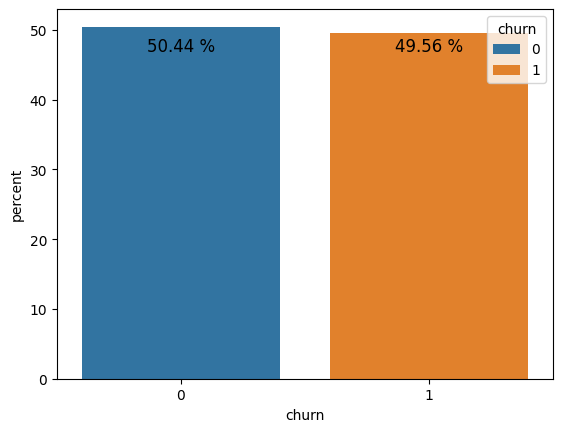

In [25]:
ax = sns.countplot(data=df, x='churn', hue="churn", stat="percent")

plt.text(0.25, 0.9, f"{stay_perc:.2f} %", fontsize=12, 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.text(0.75, 0.9, f"{leaves_perc:.2f} %", fontsize=12, 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [10]:
print(f"Deja de facturar ${df.loc[df['churn'] == 1]['rev_Mean'].sum():.2f}")

Deja de facturar $2870795.53


Lets divide group the variables by its data type.

In [11]:
list(set(df.dtypes))

[dtype('int64'), dtype('O'), dtype('float64')]

In [18]:
cols_numeric = list(df.describe(include=np.number).columns)
cols_category = list(df.describe(include=np.object0).columns)

# Features that are categorical but has numbers
features_categories_numeric = ['phones', 'models', 'truck', 'rv', 'lor', 'adults', 'numbcars', 'forgntvl', 'churn']
cols_category = cols_category + features_categories_numeric
cols_category.remove("churn")
cols_numeric = list(set(cols_numeric).difference(features_categories_numeric))

print(f"Numeric columns. Length: {len(cols_numeric)}, \n {cols_numeric}")
print(f"Category columns. Length: {len(cols_category)},\n {cols_category}")

Numeric columns. Length: 69, 
 ['ovrmou_Mean', 'iwylis_vce_Mean', 'mou_pead_Mean', 'adjmou', 'recv_sms_Mean', 'months', 'plcd_dat_Mean', 'vceovr_Mean', 'comp_vce_Mean', 'mou_rvce_Mean', 'totrev', 'drop_blk_Mean', 'threeway_Mean', 'datovr_Mean', 'avgmou', 'attempt_Mean', 'mou_opkv_Mean', 'inonemin_Mean', 'callfwdv_Mean', 'recv_vce_Mean', 'avg3qty', 'ccrndmou_Mean', 'peak_vce_Mean', 'ovrrev_Mean', 'income', 'cc_mou_Mean', 'roam_Mean', 'owylis_vce_Mean', 'da_Mean', 'unan_dat_Mean', 'avg6qty', 'adjqty', 'mou_cdat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'change_mou', 'totcalls', 'complete_Mean', 'avgqty', 'hnd_price', 'adjrev', 'unan_vce_Mean', 'opk_vce_Mean', 'avg6rev', 'rev_Mean', 'eqpdays', 'plcd_vce_Mean', 'avg6mou', 'uniqsubs', 'change_rev', 'callwait_Mean', 'peak_dat_Mean', 'mou_Mean', 'comp_dat_Mean', 'avgrev', 'mouiwylisv_Mean', 'totmrc_Mean', 'mou_cvce_Mean', 'actvsubs', 'drop_dat_Mean', 'custcare_Mean', 'opk_dat_Mean', 'avg3mou', 'totmou', 'avg3rev', 'drop_vce_Mean', 'mou_opkd_Me

In [14]:
df[cols_numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 70 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ovrmou_Mean      88116 non-null   float64
 1   iwylis_vce_Mean  89637 non-null   float64
 2   mou_pead_Mean    91060 non-null   float64
 3   adjmou           94021 non-null   float64
 4   recv_sms_Mean    99128 non-null   float64
 5   months           97706 non-null   float64
 6   plcd_dat_Mean    85020 non-null   float64
 7   vceovr_Mean      88123 non-null   float64
 8   comp_vce_Mean    95025 non-null   float64
 9   mou_rvce_Mean    92799 non-null   float64
 10  totrev           94316 non-null   float64
 11  drop_blk_Mean    92387 non-null   float64
 12  threeway_Mean    91340 non-null   float64
 13  datovr_Mean      85970 non-null   float64
 14  avgmou           95286 non-null   float64
 15  attempt_Mean     94919 non-null   float64
 16  mou_opkv_Mean    91696 non-null   float

In [11]:
replace_outliers(df)

rev_Mean  mou_Mean  totmrc_Mean  da_Mean  ovrmou_Mean  ovrrev_Mean   
0       23.9975    219.25       22.500   0.2475         0.00          0.0  \
1       57.4925    482.75       37.425   0.2475        22.75          9.1   
2       16.9900     10.25       16.990   0.0000         0.00          0.0   
3       38.0000      7.50       38.000   0.0000         0.00          0.0   
4       55.2300    570.50       71.980   0.0000         0.00          0.0   
...         ...       ...          ...      ...          ...          ...   
99995       NaN       NaN          NaN      NaN          NaN          NaN   
99996       NaN       NaN          NaN      NaN          NaN          NaN   
99997       NaN       NaN          NaN      NaN          NaN          NaN   
99998       NaN       NaN          NaN      NaN          NaN          NaN   
99999       NaN       NaN          NaN      NaN          NaN          NaN   

       vceovr_Mean  datovr_Mean  roam_Mean  change_mou  ...  forgntvl  ethnic   
0              0.0          0.0        0.0     -157.25  ...       0.0       N  \
1              9.1          0.0        0.0         NaN  ...       0.0       Z   
2              0.0          0.0        0.0       -4.25  ...       0.0       N   
3              0.0          0.0        0.0       -1.50  ...       0.0       U   
4              0.0          0.0        0.0       38.50  ...       0.0       I   
...            ...          ...        ...         ...  ...       ...     ...   
99995          NaN          NaN        NaN         NaN  ...       0.0       S   
99996          NaN          NaN        NaN         NaN  ...       0.0       N   
99997          NaN          NaN        NaN         NaN  ...       0.0       U   
99998          NaN          NaN        NaN         NaN  ...       0.0       S   
99999          NaN          NaN        NaN         NaN  ...       0.0       H   

       kid0_2  kid3_5  kid6_10  kid11_15  kid16_17  creditcd  eqpdays   
0           U       U        U         U         U         Y    361.0  \
1           U       U        U         U         U         Y    240.0   
2           U       Y        U         U         U         Y      NaN   
3           Y       U        U         U         U         Y      NaN   
4           U       U        U         U         U         Y    434.0   
...       ...     ...      ...       ...       ...       ...      ...   
99995       U       U        U         Y         U         Y    773.0   
99996       U       U        Y         Y         Y         Y    835.0   
99997       Y       Y        U         U         U         N    433.0   
99998       U       U        U         U         U         N     75.0   
99999       U       U        U         U         U         N      5.0   

       Customer_ID  
0          1000001  
1          1000002  
2          1000003  
3          1000004  
4          1000005  
...            ...  
99995      1099996  
99996      1099997  
99997      1099998  
99998      1099999  
99999      1100000  

[100000 rows x 100 columns]

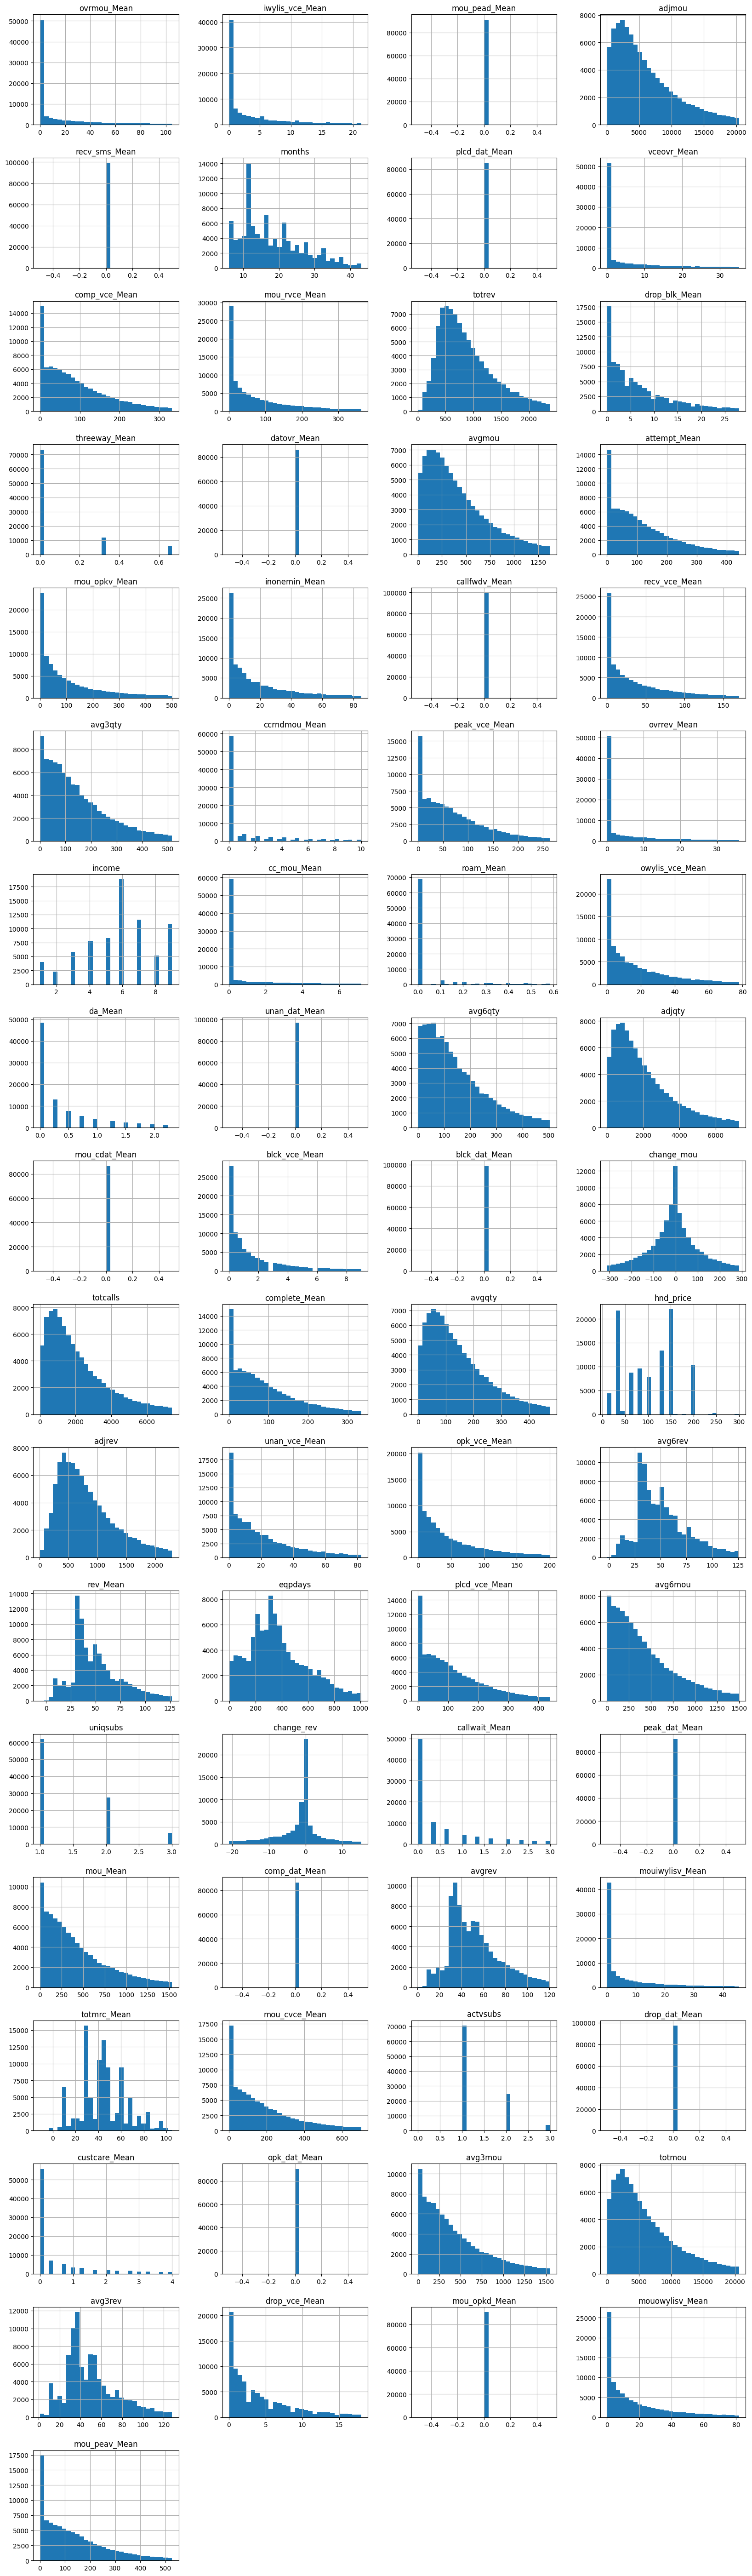

In [19]:
df[cols_numeric].hist(bins=30, figsize = (20, 80), layout=(20,4), hue="churn");

c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


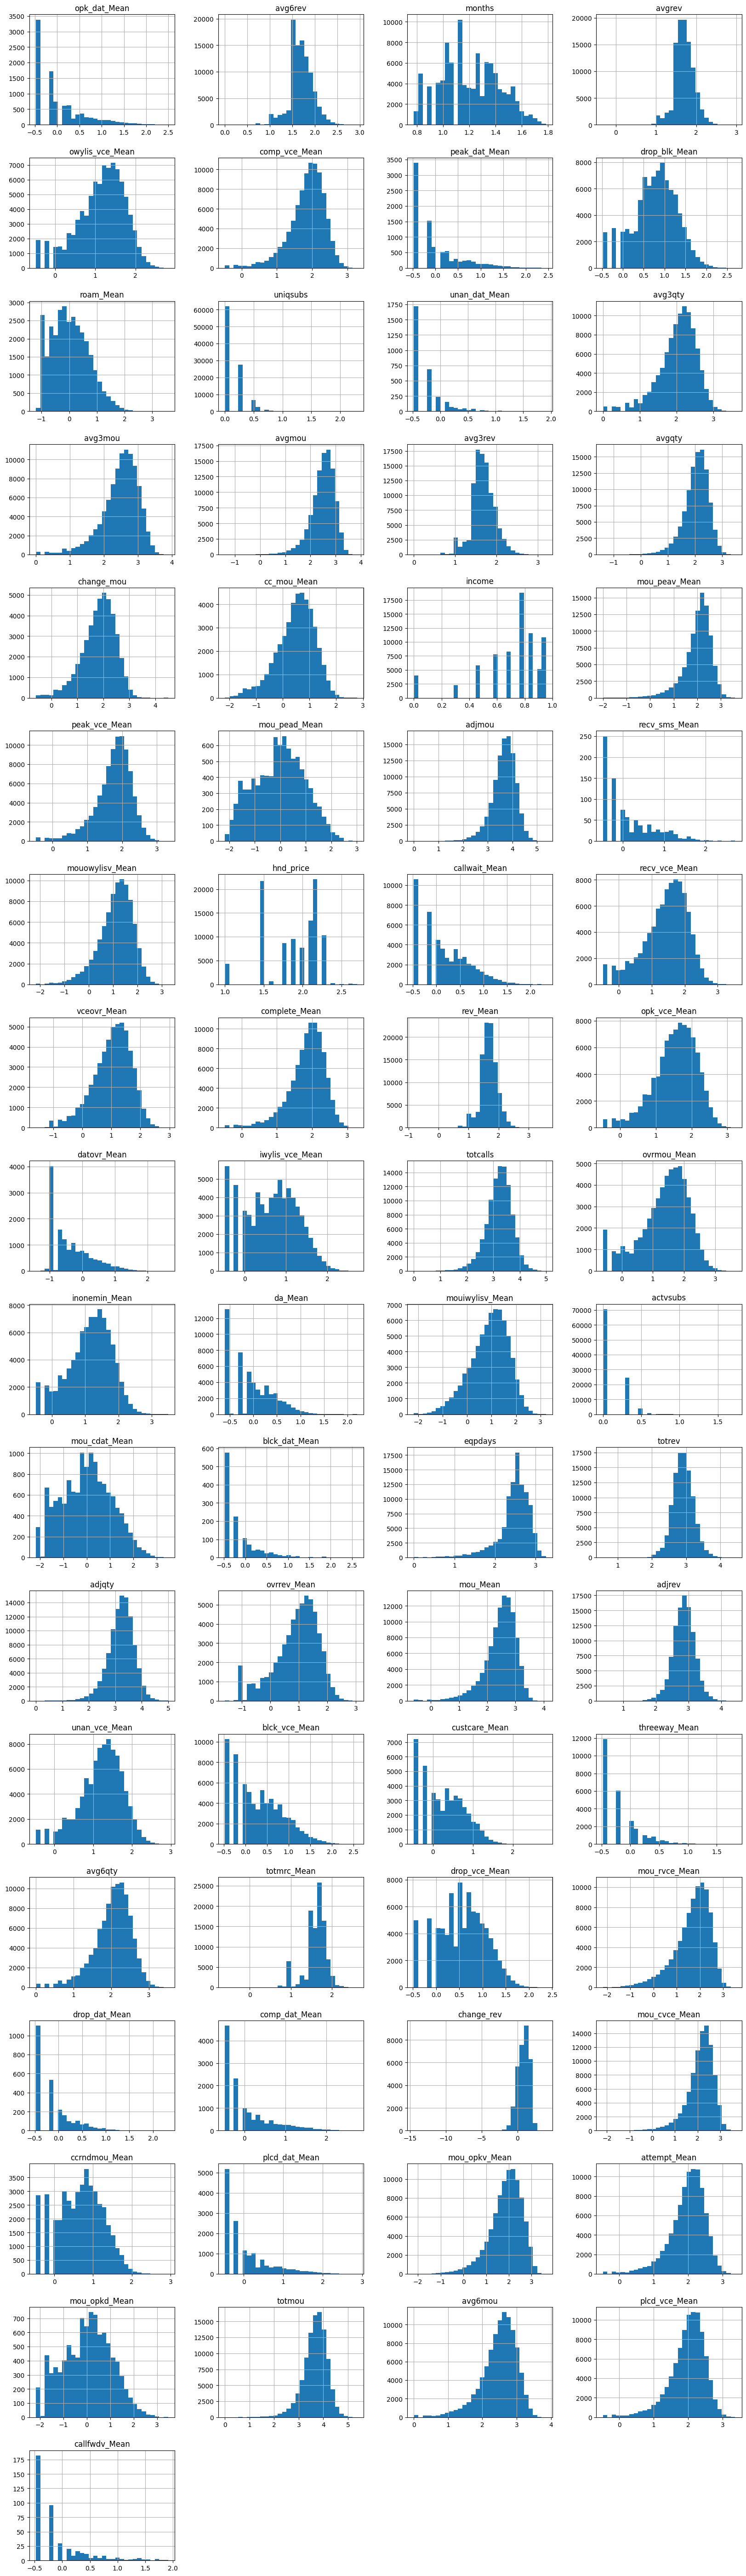

In [90]:
df_log = np.log10(df[cols_numeric])
df_log[abs(df_log)==np.inf] = np.NaN
df_log[cols_numeric].hist(bins=30, figsize=(20, 80), layout=(20,4));

In [16]:
scaler = StandardScaler()

zscaled_values = scaler.fit_transform(df_log)
column_features = scaler.get_feature_names_out()

# Get the transformed dataframe
df_zscaled = pd.DataFrame(data=zscaled_values, columns=column_features)

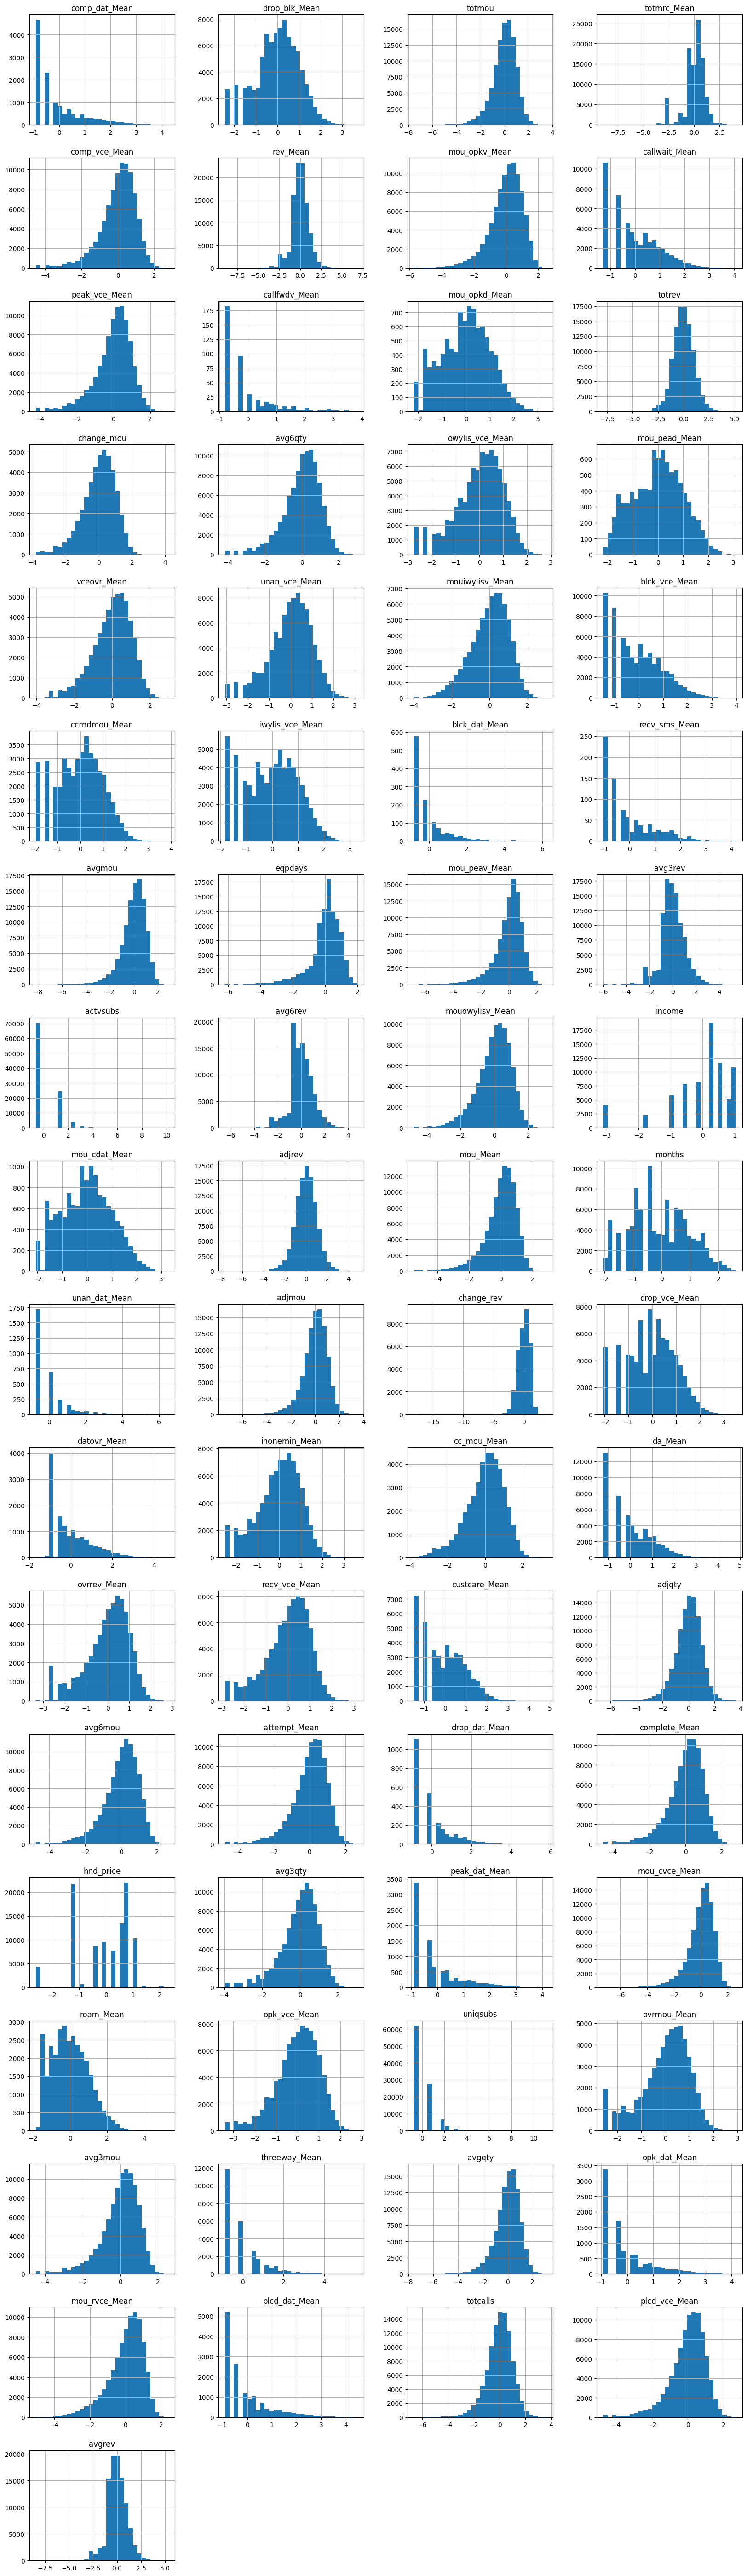

In [17]:
df_zscaled.hist(bins=30, figsize=(20, 80), layout=(20,4));

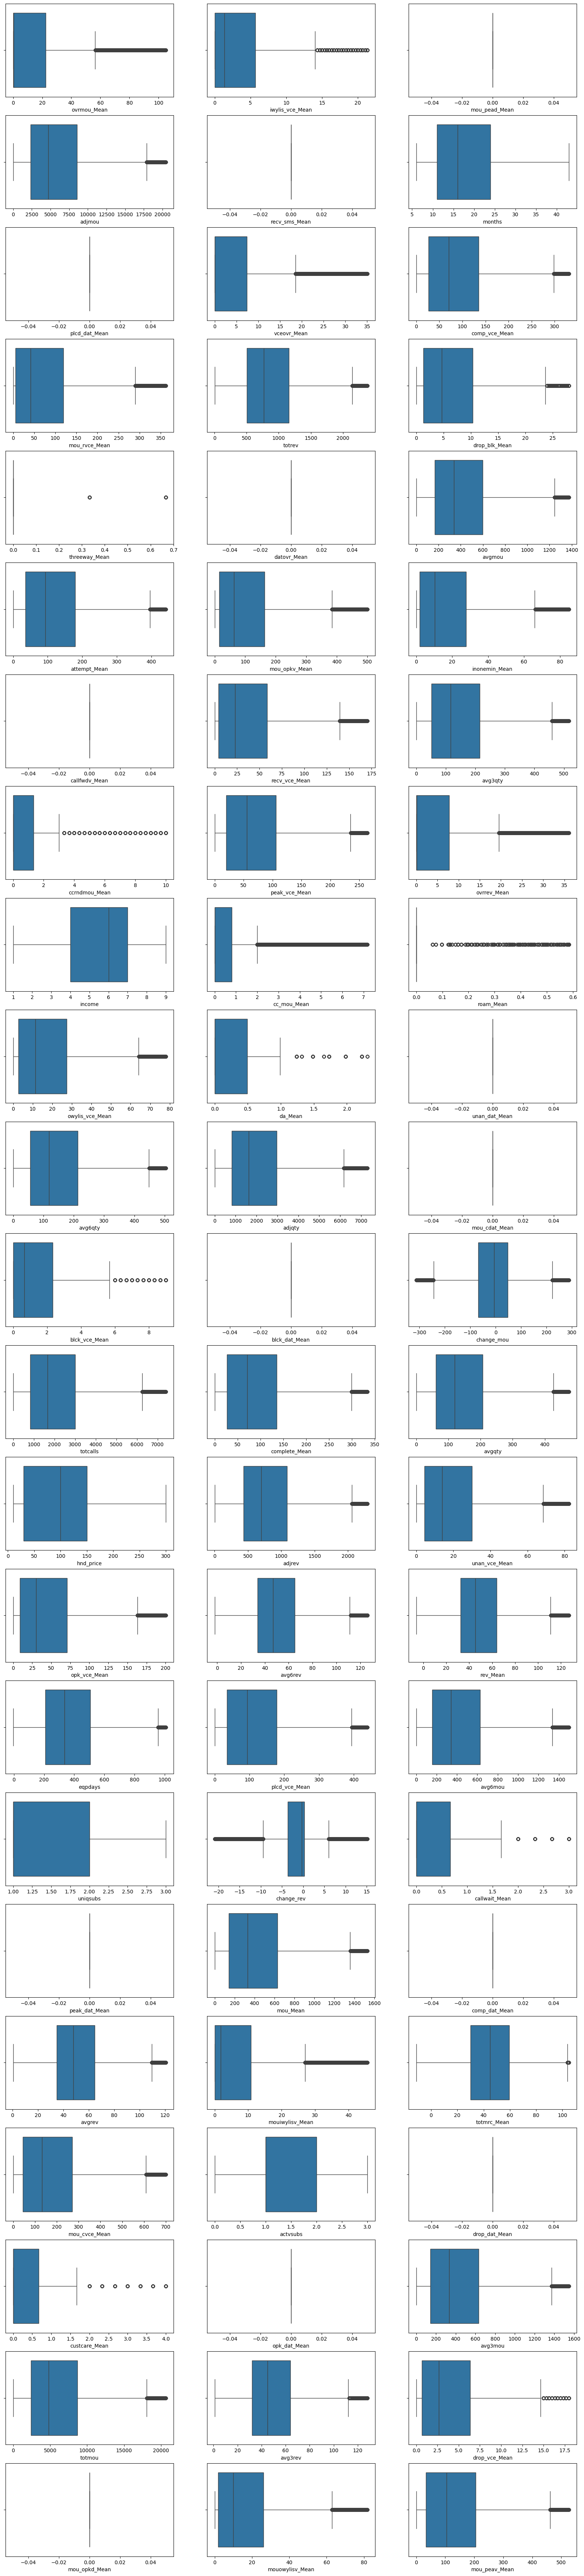

In [20]:
ncols = 3
nrows = int(np.ceil(len(cols_numeric)/ncols))
fig, axes = plt.subplots(figsize=(20,90), ncols=ncols, nrows=nrows)

for i, ax in enumerate(axes.flat):
    variable = cols_numeric[i]
    sns.boxplot(data=df, x=variable,  ax=ax)#x=np.log(df[variable]),  ax=ax)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


In [93]:
scaler = StandardScaler()

zscaled = scaler.fit_transform(df[cols_numeric])
column_features = scaler.get_feature_names_out()

# Get the transformed dataframe
df_zscaled = pd.DataFrame(data=zscaled, columns=column_features)

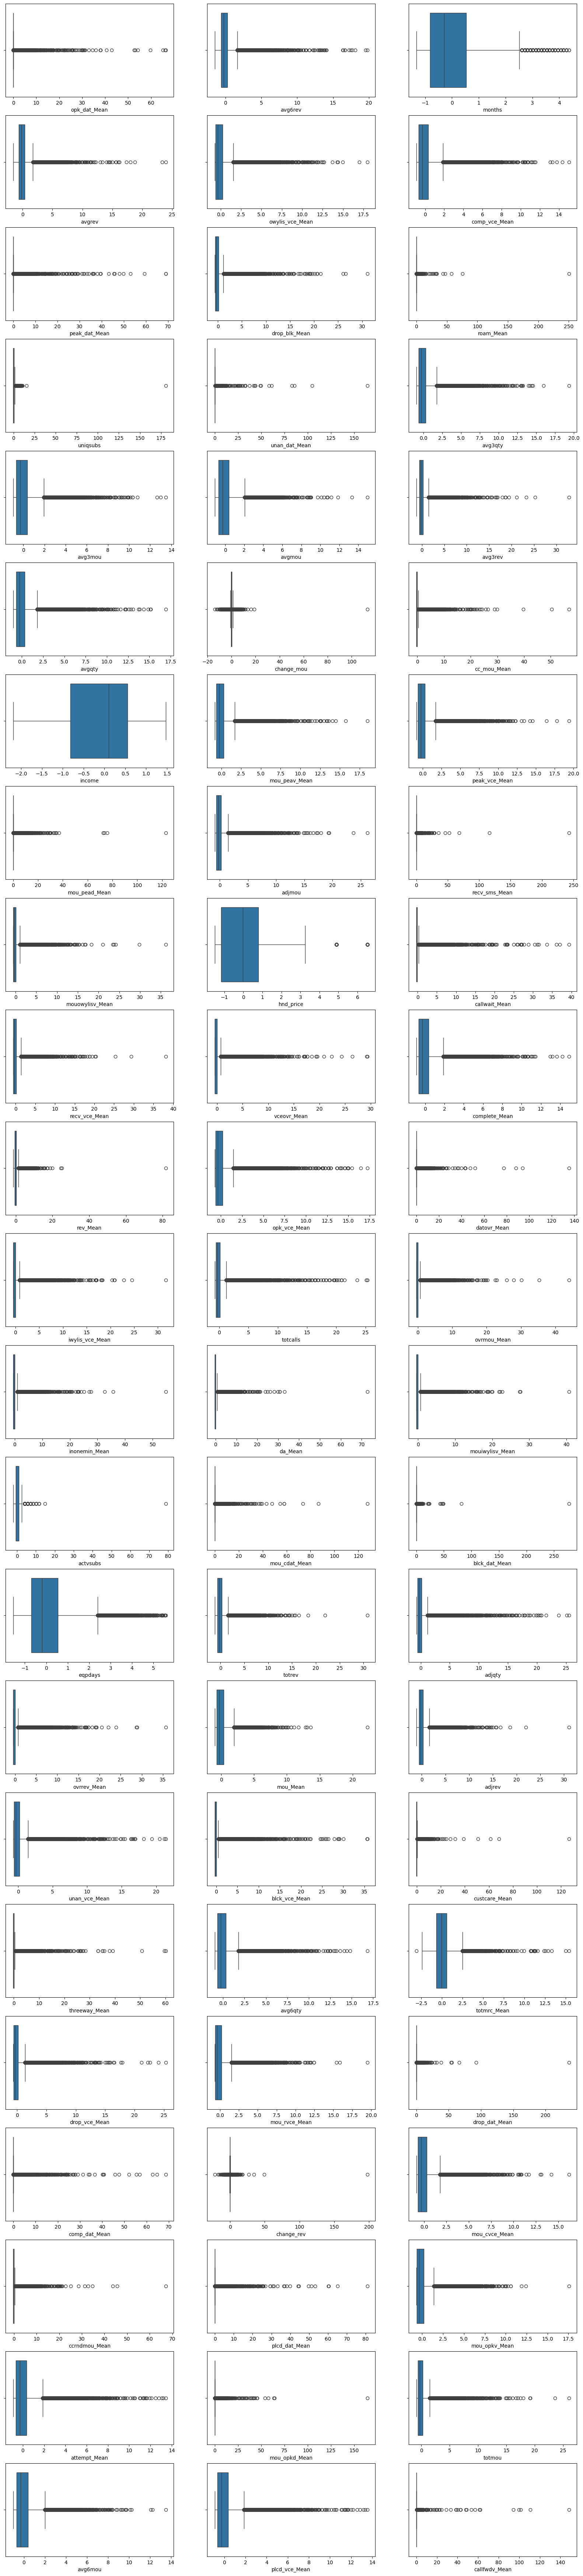

In [94]:
ncols = 3
nrows = int(np.ceil(len(cols_numeric)/ncols))
fig, axes = plt.subplots(figsize=(20,90), ncols=ncols, nrows=nrows)

for i, ax in enumerate(axes.flat):
    variable = cols_numeric[i]
    sns.boxplot(data=df_zscaled, x=variable,  ax=ax)#x=np.log(df[variable]),  ax=ax)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


## Churn relationship with other variables

C:\Users\daniel.lopezcoto\AppData\Local\Temp\ipykernel_19976\1196154742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
C:\Users\daniel.lopezcoto\AppData\Local\Temp\ipykernel_19976\1196154742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
C:\Users\daniel.lopezcoto\AppData\Local\Temp\ipykernel_19976\1196154742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
C:\Users\daniel.lopezcoto\AppData\Local\Temp\ipykernel_19976\1196154742.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
C:\Users\daniel.lopezcoto\AppData\Local\Temp\ipykernel_19976\1196154742.py:8: UserWarning: FixedFormatter should only be used together with 

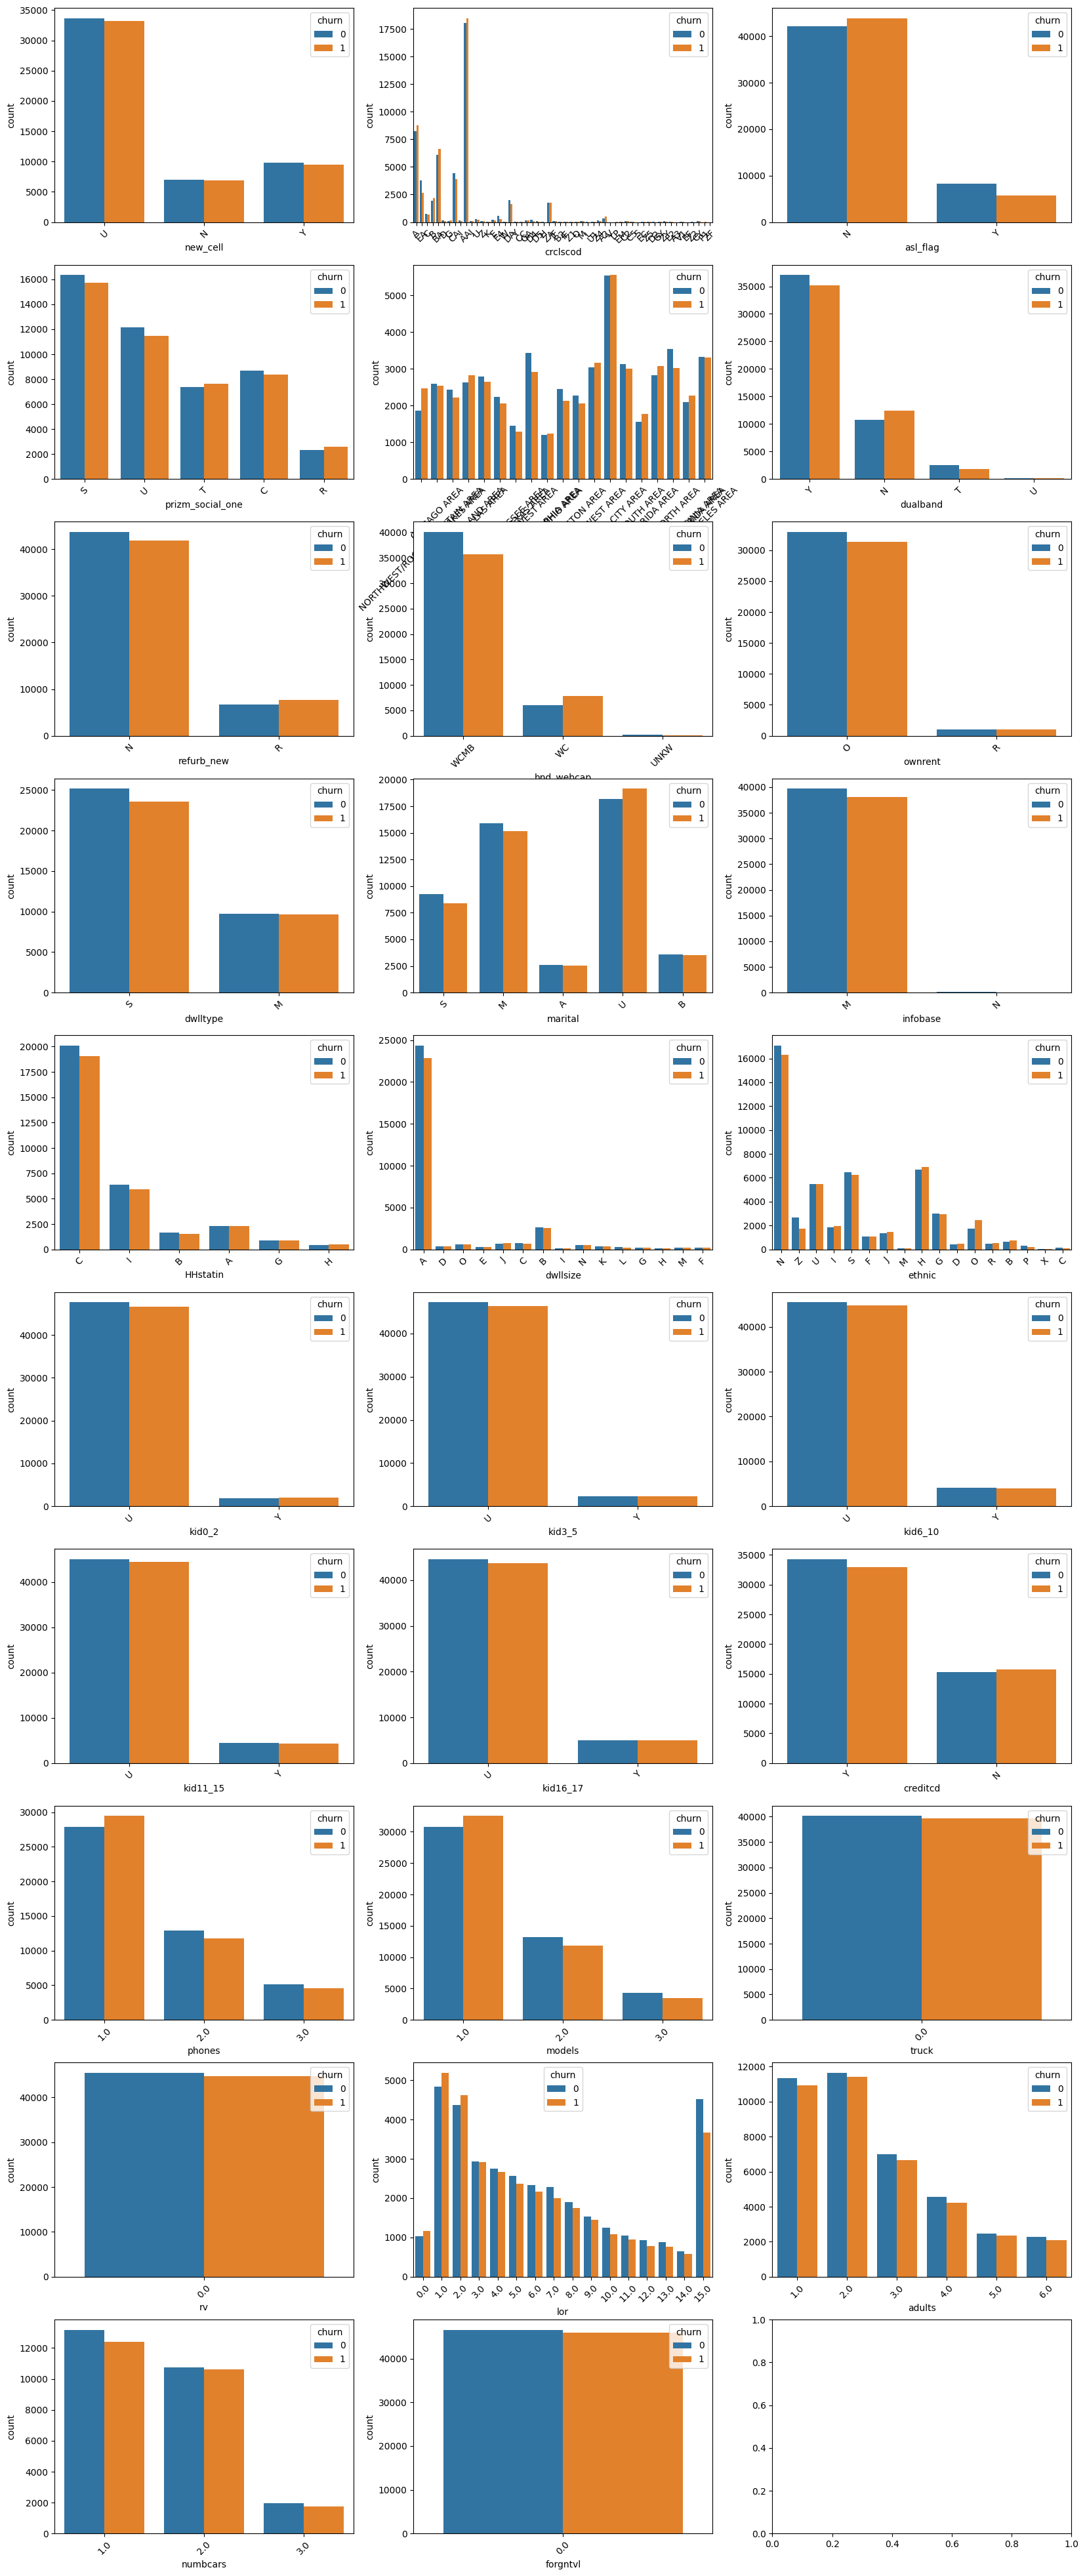

In [21]:
ncols = 3
nrows = int(np.ceil(len(cols_category)/ncols))
fig, axes = plt.subplots(figsize=(20,50), ncols=ncols, nrows=nrows)
ax = axes.flat

for i, category in enumerate(cols_category):
    sns.countplot(data=df, x=category, hue="churn", ax=ax[i])#, stat="percent")
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)


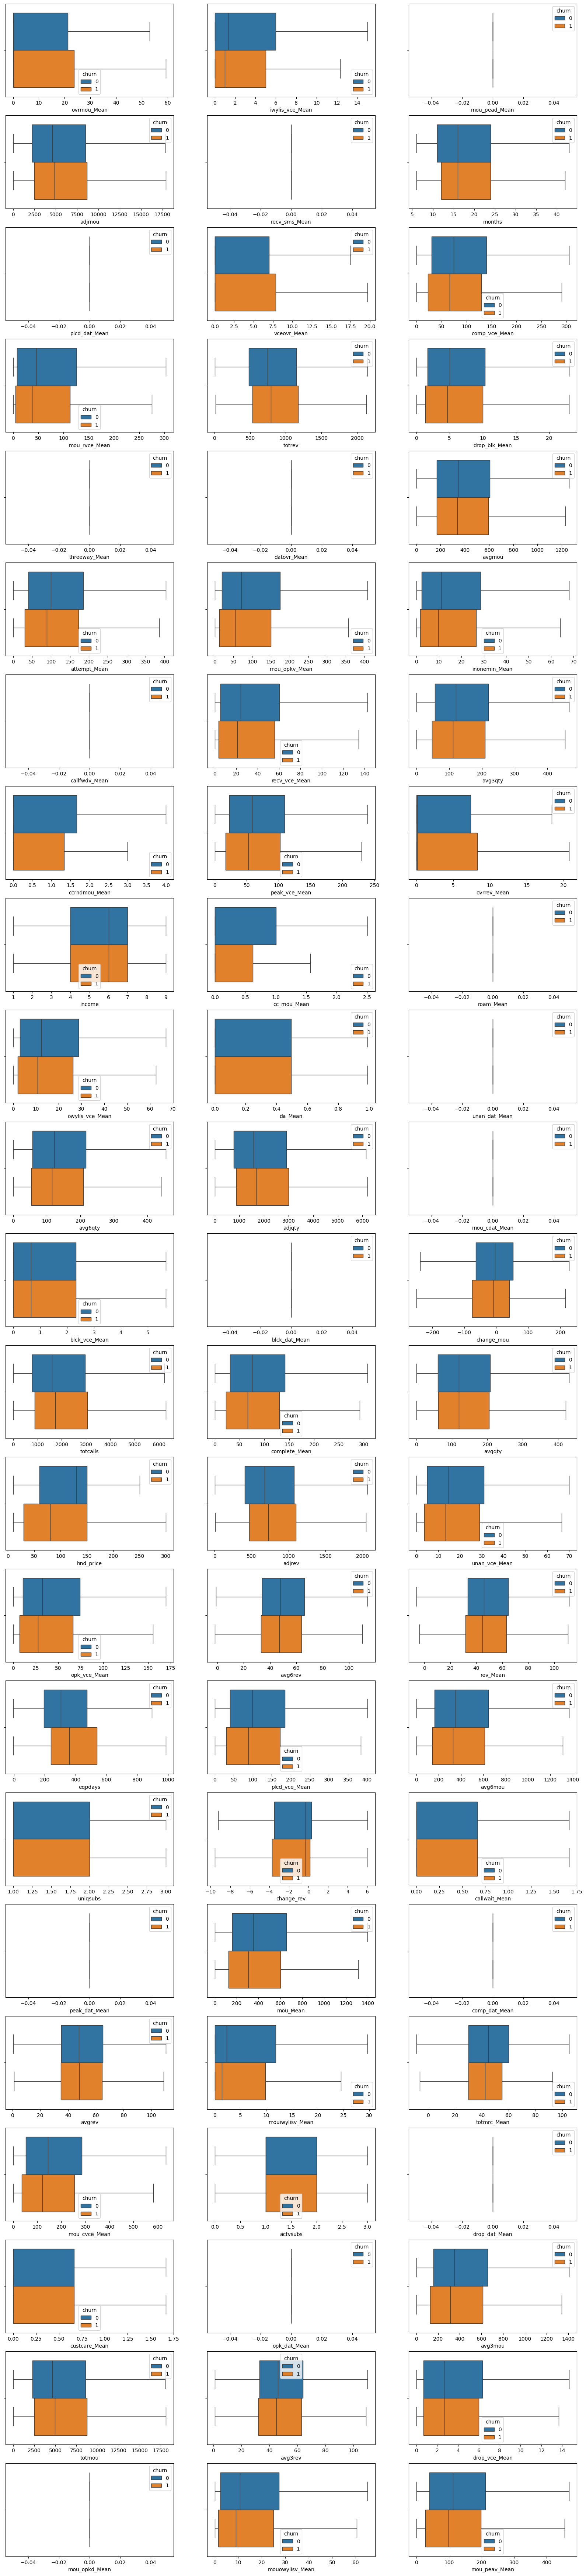

In [23]:
ncols = 3
nrows = int(np.ceil(len(cols_numeric)/ncols))
fig, axes = plt.subplots(figsize=(20,90), ncols=ncols, nrows=nrows)

ax = axes.flat

for i, variable in enumerate(cols_numeric):
    sns.boxplot(data=df, x=variable, hue="churn", ax=ax[i], showfliers=False)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


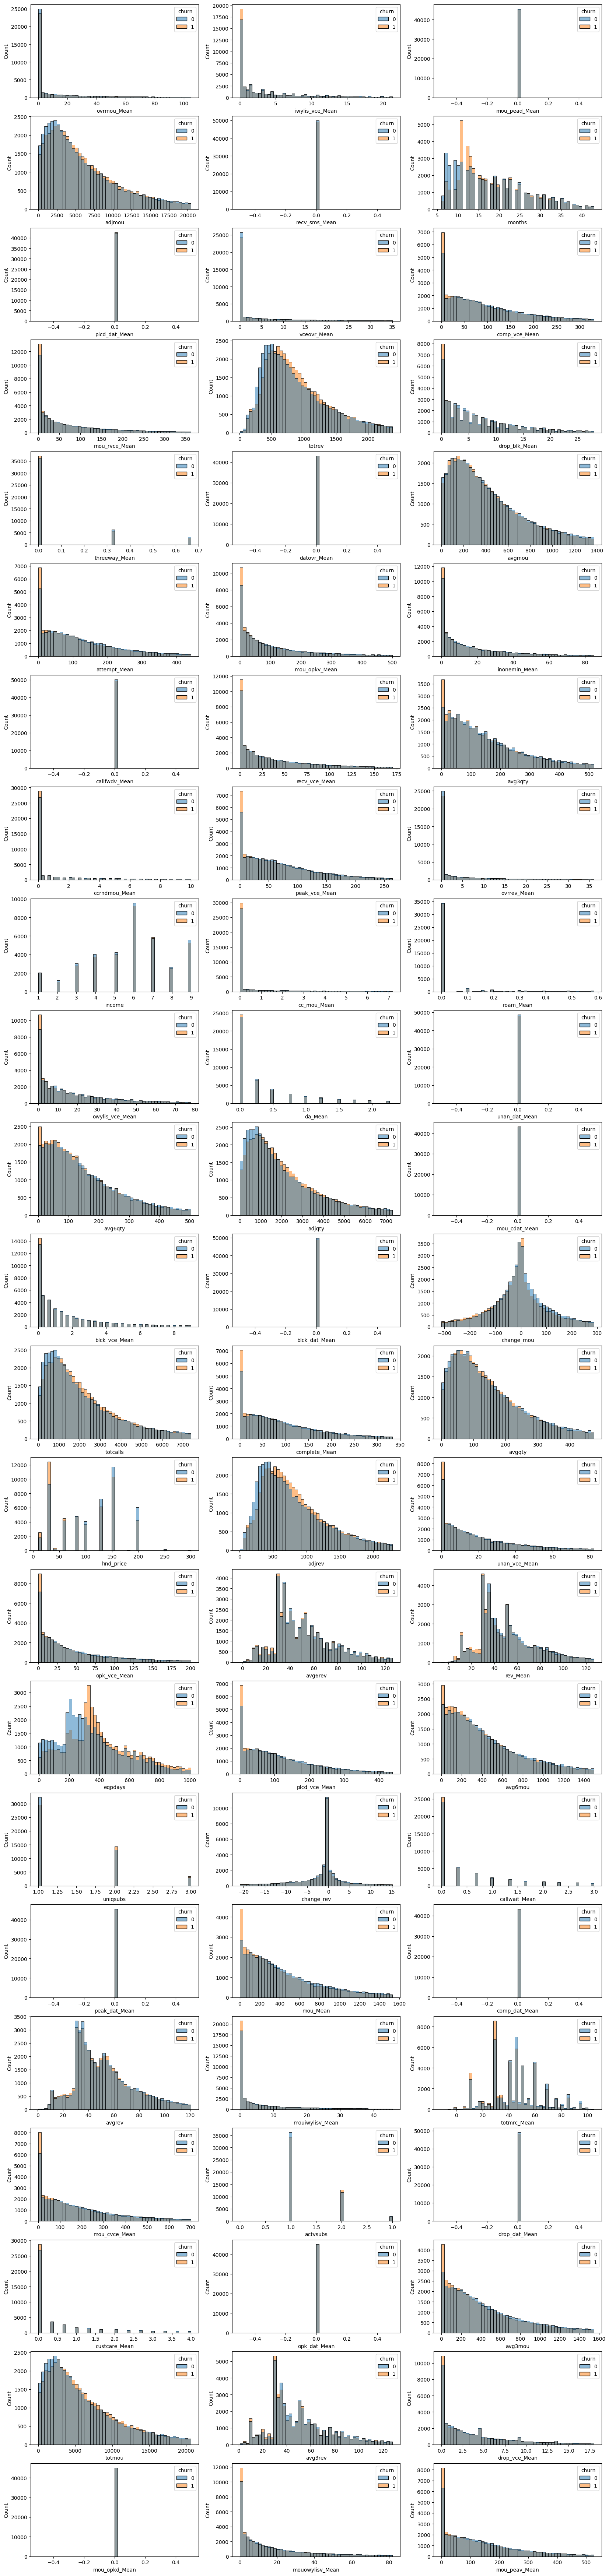

In [28]:
ncols = 3
nrows = int(np.ceil(len(cols_numeric)/ncols))
fig, axes = plt.subplots(figsize=(20,90), ncols=ncols, nrows=nrows)

ax = axes.flat

for i, variable in enumerate(cols_numeric):
    sns.histplot(data=df, x=variable, hue="churn", ax=ax[i], bins=50)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\daniel.lopezcoto\.virtualenvs\daniel.lopezcoto-KNaZ5Qew\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

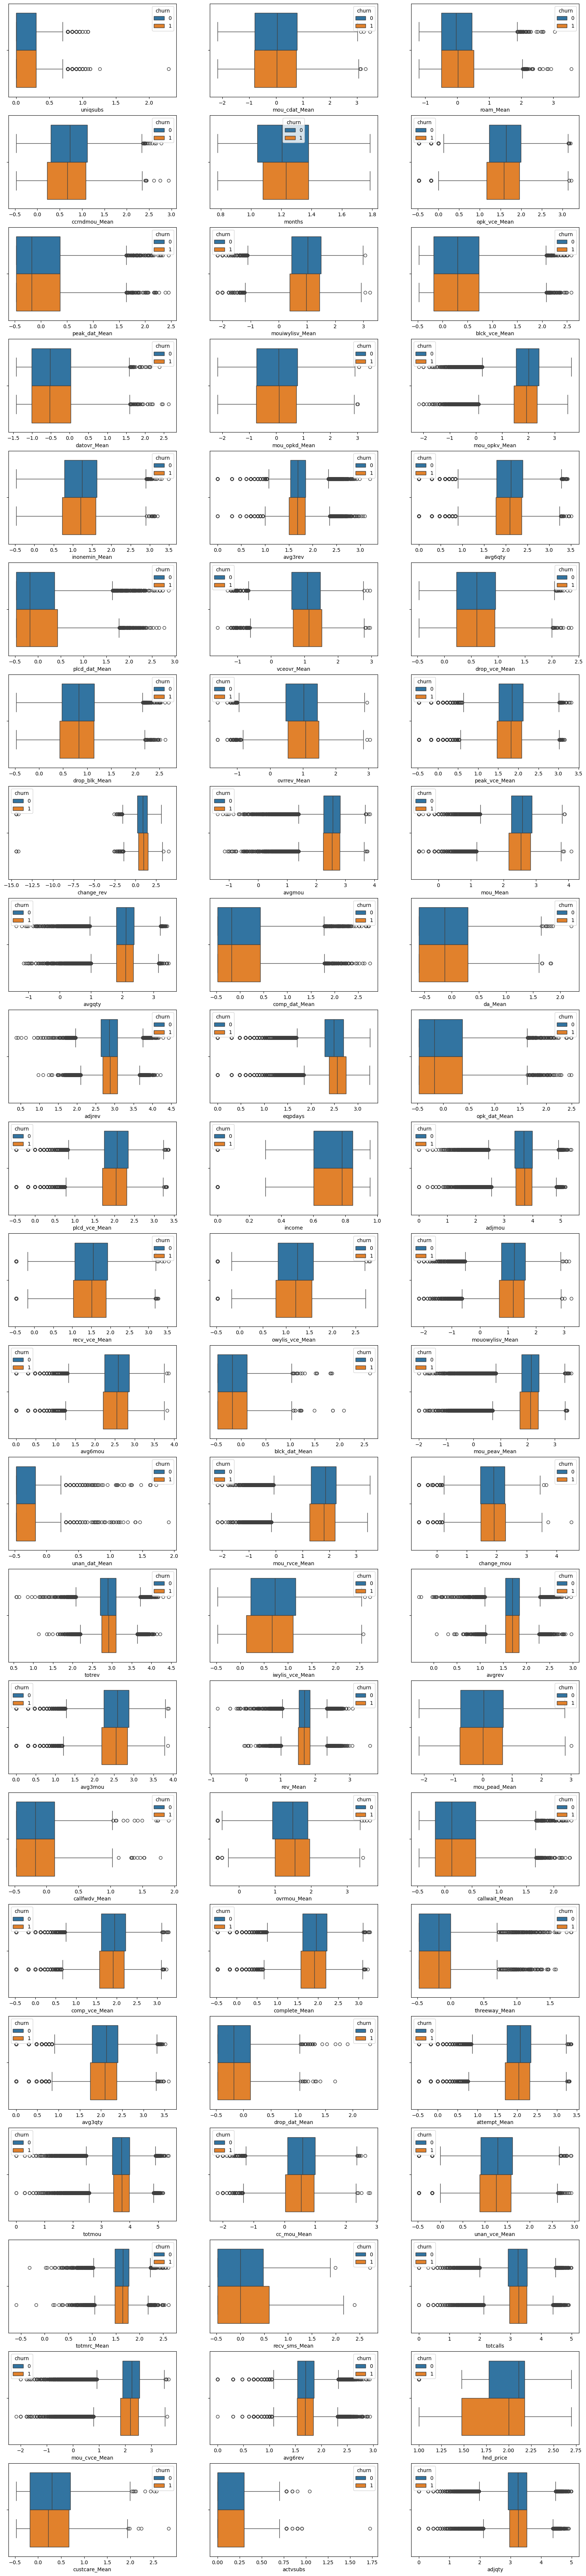

In [6]:
ncols = 3
nrows = int(np.ceil(len(cols_numeric)/ncols))
fig, axes = plt.subplots(figsize=(20,90), ncols=ncols, nrows=nrows)

ax = axes.flat

for i, variable in enumerate(cols_numeric):
    sns.boxplot(data=df, x=np.log10(df[variable]), hue="churn", ax=ax[i])
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


Column: rev_Mean
Point-Biserial Correlation: -0.011701631573738347
P-value: 0.0002152079533915183

Column: mou_Mean
Point-Biserial Correlation: -0.05815898539473195
P-value: 1.1579145059559133e-75

Column: totmrc_Mean
Point-Biserial Correlation: -0.06850252125622007
P-value: 2.6860482166445338e-104

Column: da_Mean
Point-Biserial Correlation: -0.014078950656848345
P-value: 8.494740085527376e-06

Column: ovrmou_Mean
Point-Biserial Correlation: 0.019102784765801347
P-value: 1.5287112989407086e-09

Column: ovrrev_Mean
Point-Biserial Correlation: 0.023079186318256353
P-value: 2.895688948354609e-13

Column: vceovr_Mean
Point-Biserial Correlation: 0.02358528714862014
P-value: 8.700517938340574e-14

Column: datovr_Mean
Point-Biserial Correlation: -0.0014013454698509461
P-value: 0.6576651790653776

Column: roam_Mean
Point-Biserial Correlation: 0.009187856606940655
P-value: 0.003666898489931614

Column: change_mou
Point-Biserial Correlation: -0.03115318136876498
P-value: 6.602052466292482e-23



## Correlation between numeric variables

<Axes: >

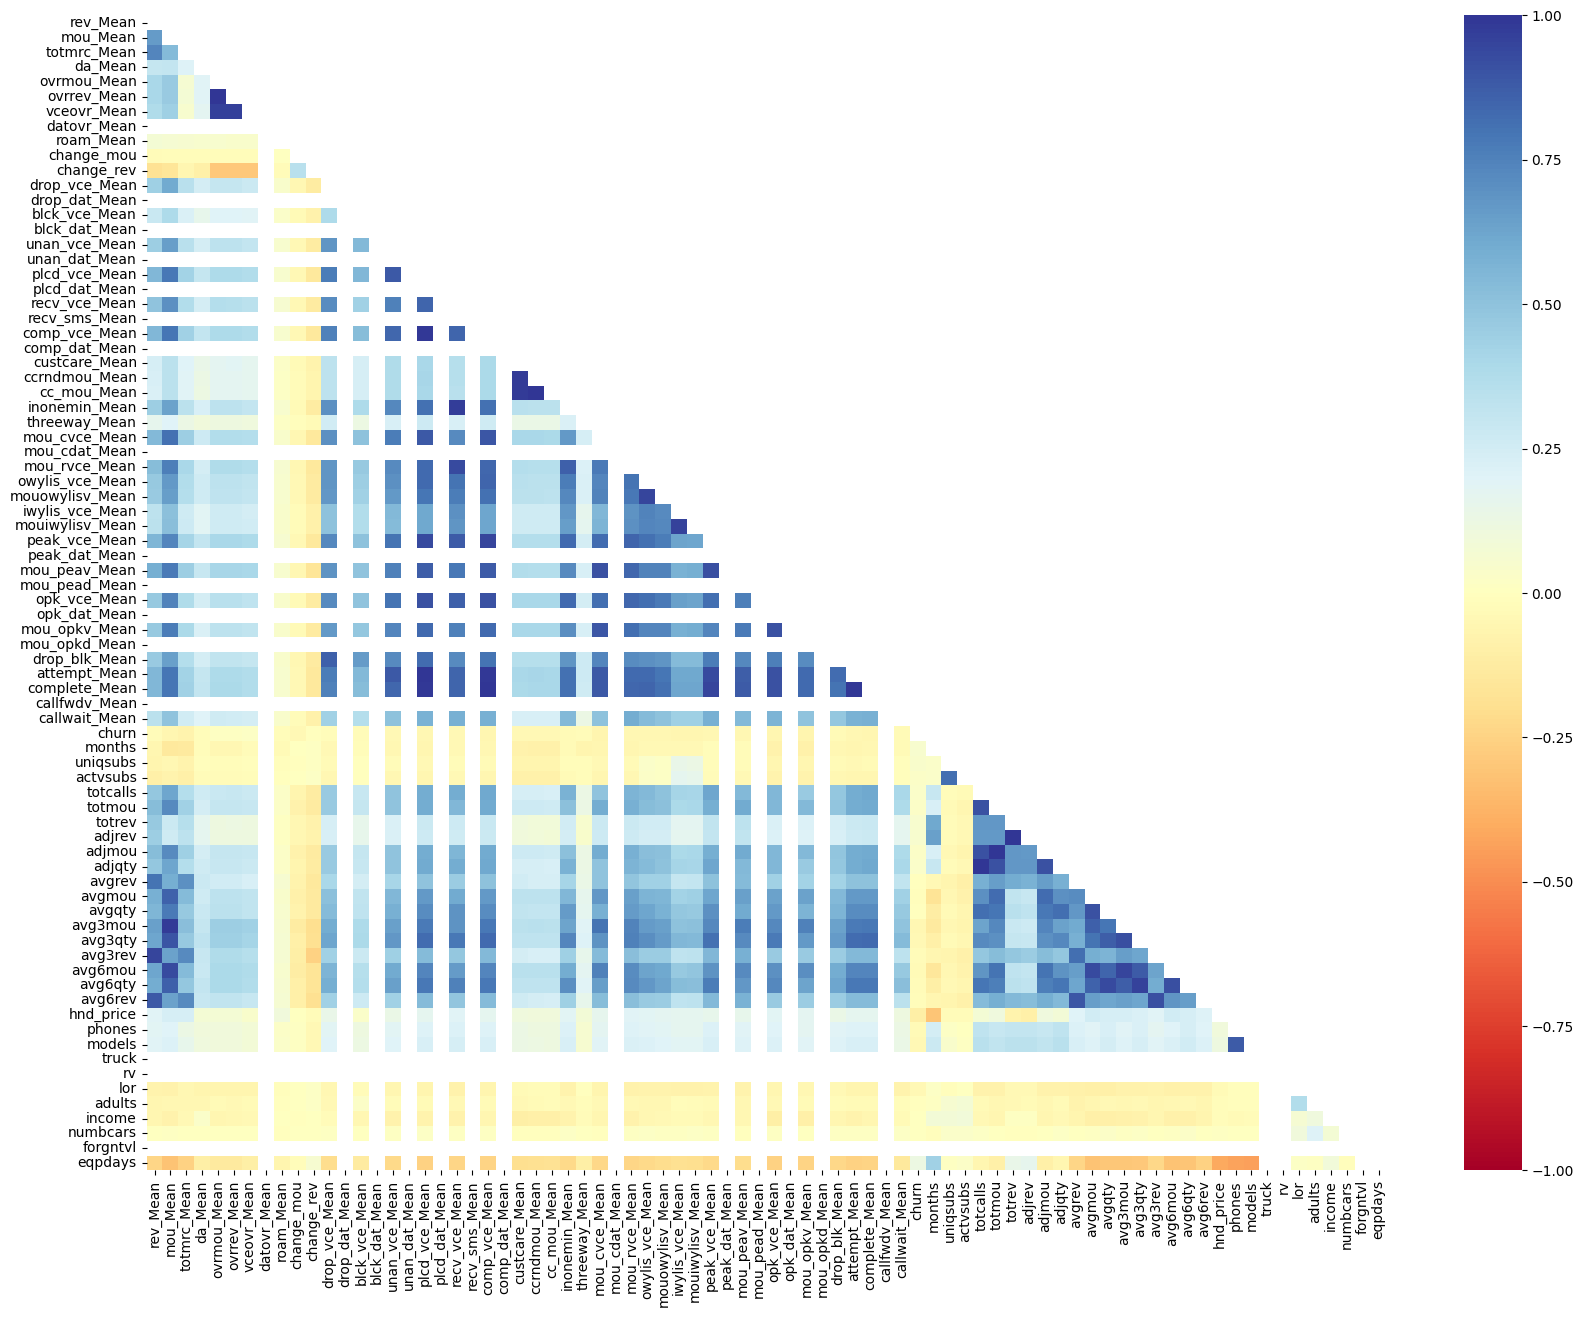

In [24]:
correlation = df.select_dtypes('number').corr(method="spearman")

fig, ax = plt.subplots(figsize=(20,15))
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation, ax=ax, cmap="RdYlBu", annot=False, mask=mask, vmin=-1, vmax=1)

<Axes: >

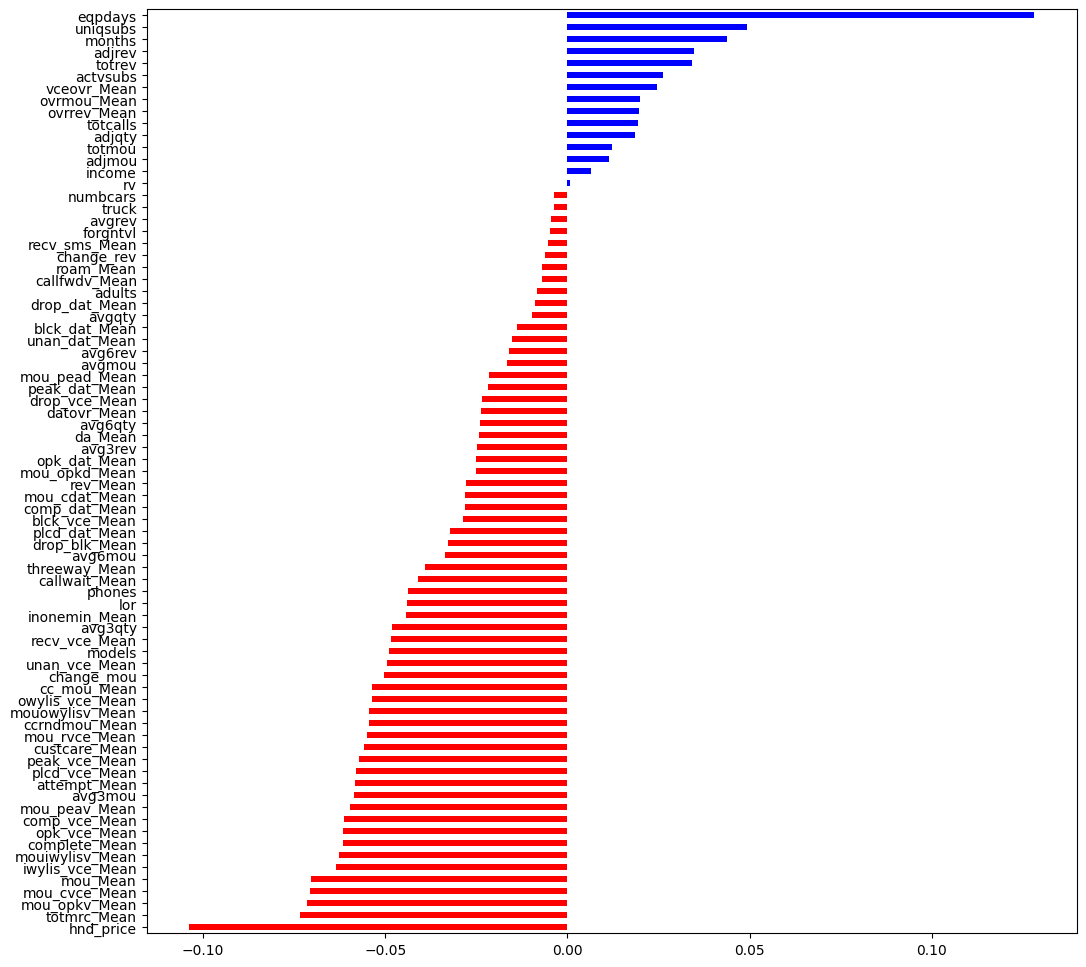

In [51]:
fig, ax = plt.subplots(figsize=(12, 12))

churn_corr = correlation.loc["churn", correlation.columns != "churn"].sort_values(ascending=True)
cc = np.where(churn_corr > 0, 'blue', 'red')
churn_corr.plot(kind="barh", color=cc, ax=ax)

Column: rev_Mean
Point-Biserial Correlation: -0.011701631573738347
P-value: 0.0002152079533915183

Column: eqpdays
Point-Biserial Correlation: 0.11269395698192944
P-value: 6.51166634840786e-280

Column: drop_blk_Mean
Point-Biserial Correlation: -0.01585102591848899
P-value: 5.36473407501448e-07

Column: uniqsubs
Point-Biserial Correlation: 0.039882215507254556
P-value: 1.7077550441523334e-36

Column: actvsubs
Point-Biserial Correlation: 0.019685692917039026
P-value: 4.794470333321313e-10

Column: custcare_Mean
Point-Biserial Correlation: -0.03639289339820279
P-value: 1.1463501268881248e-30

Column: complete_Mean
Point-Biserial Correlation: -0.0517404985522351
P-value: 3.003907780426668e-60

Column: attempt_Mean
Point-Biserial Correlation: -0.04853333391054723
P-value: 3.20683235857256e-53

Column: hnd_price
Point-Biserial Correlation: -0.10419705794017346
P-value: 2.1975534891559175e-239

Column: months
Point-Biserial Correlation: 0.020990975676192382
P-value: 3.1672429357676767e-11

C

<Axes: >

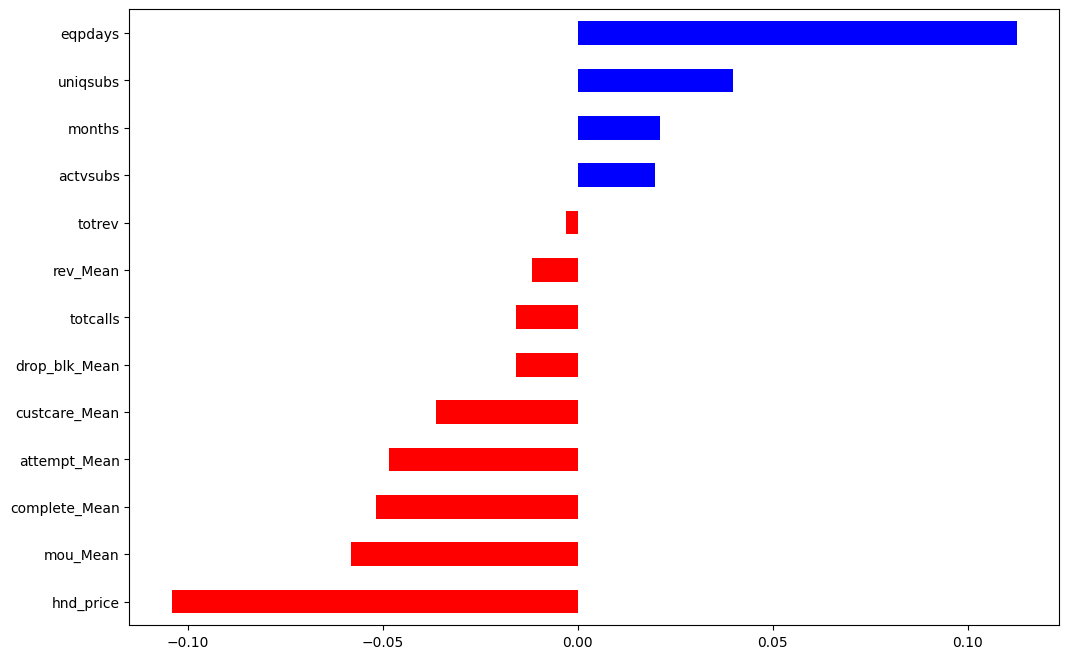

In [110]:

correlation_list = []
p_value = []

for col in feat_num_to_keep:
    correl, p_val = pointbiserialr(df.churn, df[col])
    correlation_list.append(correl)
    p_value.append(p_val)
    print(f"Column: {col}")
    print("Point-Biserial Correlation:", correl)
    print("P-value:", p_val)
    print()


pbisi_dict = {'correlation_coef': correlation_list,
              'p_value': p_value}

df_pbiserial_corr = pd.DataFrame(data=pbisi_dict, index=feat_num_to_keep)

fig, ax = plt.subplots(figsize=(12, 8))

churn_corrbisiearl = df_pbiserial_corr['correlation_coef'].sort_values(ascending=True)
cc = np.where(churn_corrbisiearl > 0, 'blue', 'red')
churn_corrbisiearl.plot(kind="barh", color=cc, ax=ax)

#### Point bi-serial correlation

Column: rev_Mean
Point-Biserial Correlation: -0.011701631573738347
P-value: 0.0002152079533915183

Column: mou_Mean
Point-Biserial Correlation: -0.05815898539473195
P-value: 1.1579145059559133e-75

Column: totmrc_Mean
Point-Biserial Correlation: -0.06850252125622007
P-value: 2.6860482166445338e-104

Column: da_Mean
Point-Biserial Correlation: -0.014078950656848345
P-value: 8.494740085527376e-06

Column: ovrmou_Mean
Point-Biserial Correlation: 0.019102784765801347
P-value: 1.5287112989407086e-09

Column: ovrrev_Mean
Point-Biserial Correlation: 0.023079186318256353
P-value: 2.895688948354609e-13

Column: vceovr_Mean
Point-Biserial Correlation: 0.02358528714862014
P-value: 8.700517938340574e-14

Column: datovr_Mean
Point-Biserial Correlation: -0.0014013454698509461
P-value: 0.6576651790653776

Column: roam_Mean
Point-Biserial Correlation: 0.009187856606940655
P-value: 0.003666898489931614

Column: change_mou
Point-Biserial Correlation: -0.03115318136876498
P-value: 6.602052466292482e-23



<Axes: >

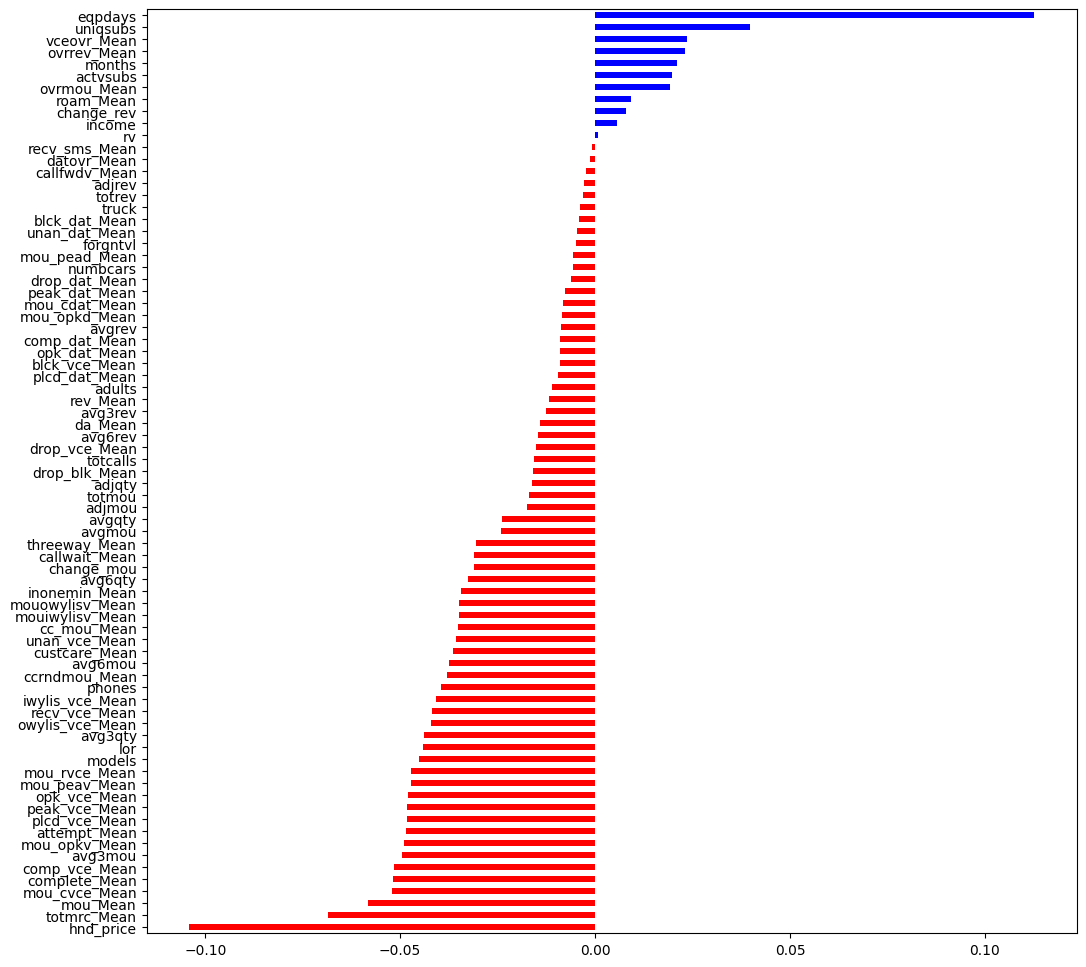

In [44]:
# Point bi-serieal correlation to test the correlation between the dycotomus variable and the rest numerical variables.

num_cols = df.select_dtypes('number').columns.to_list()
df[num_cols] = df[num_cols].fillna(df[num_cols].mode().iloc[0])
num_cols.remove("churn")

correlation_list = []
p_value = []

for col in num_cols:
    correl, p_val = pointbiserialr(df.churn, df[col])
    correlation_list.append(correl)
    p_value.append(p_val)
    print(f"Column: {col}")
    print("Point-Biserial Correlation:", correl)
    print("P-value:", p_val)
    print()


pbisi_dict = {'correlation_coef': correlation_list,
              'p_value': p_value}

df_pbiserial_corr = pd.DataFrame(data=pbisi_dict, index=num_cols)

fig, ax = plt.subplots(figsize=(12, 12))

churn_corrbisiearl = df_pbiserial_corr['correlation_coef'].sort_values(ascending=True)
cc = np.where(churn_corrbisiearl > 0, 'blue', 'red')
churn_corrbisiearl.plot(kind="barh", color=cc, ax=ax)

In [78]:
series_pbisieral_corr = df_pbiserial_corr[df_pbiserial_corr.p_value<0.05].correlation_coef

pbis_corr_dict = series_pbisieral_corr.to_dict()

In [45]:
high_corr = correlation[((correlation > 0.85) | (correlation < -0.85))]

features_high_corr = dict()
for col in high_corr.columns:
    feature_names = list(high_corr.index[high_corr[col].notna()])
    if len(feature_names) > 1:
        feature_names.remove(col)
        features_high_corr[col] = feature_names

for key, value in features_high_corr.items():
    print(key)
    print(value)
    column = key.split(" ") + value
    #print(df[column].isna().sum())
    print()

rev_Mean
['avg3rev', 'avg6rev']

mou_Mean
['avgmou', 'avg3mou', 'avg3qty', 'avg6mou']

ovrmou_Mean
['ovrrev_Mean', 'vceovr_Mean']

ovrrev_Mean
['ovrmou_Mean', 'vceovr_Mean']

vceovr_Mean
['ovrmou_Mean', 'ovrrev_Mean']

drop_vce_Mean
['drop_blk_Mean']

unan_vce_Mean
['plcd_vce_Mean', 'comp_vce_Mean', 'attempt_Mean', 'complete_Mean']

plcd_vce_Mean
['unan_vce_Mean', 'recv_vce_Mean', 'comp_vce_Mean', 'mou_cvce_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'peak_vce_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'mou_opkv_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean']

plcd_dat_Mean
['comp_dat_Mean', 'mou_cdat_Mean']

recv_vce_Mean
['plcd_vce_Mean', 'comp_vce_Mean', 'inonemin_Mean', 'mou_rvce_Mean', 'peak_vce_Mean', 'opk_vce_Mean', 'attempt_Mean', 'complete_Mean']

comp_vce_Mean
['unan_vce_Mean', 'plcd_vce_Mean', 'recv_vce_Mean', 'mou_cvce_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'peak_vce_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'mou_opkv_Mean', 'attempt_Mean', 'complete_Mean', 'avg3qty'

In [91]:
def seleccionar_variables_correlacionadas(series_pbisieral_corr: pd.Series, features_high_corr:dict):
    """
    Selecciona las variables cuyo coeficiente de correlación con la variable objetivo es mayor en valor absoluto.

    Args:
    - correlaciones (dict): Un diccionario donde las llaves son los nombres de las variables y los valores son los coeficientes de correlación.
    - features_high_corr (dict): Un diccionario donde las llaves son los nombres de las variables y los valores son listas de variables correlacionadas.

    Returns:
    - variables_seleccionadas (list): Una lista de variables cuyo coeficiente de correlación con la variable objetivo es mayor en valor absoluto.
    """
    vars_to_keep = []

    for key, values in features_high_corr.items():
        if key in series_pbisieral_corr:
            vars_to_check = [v for v in features_high_corr.get(key) if v in series_pbisieral_corr]
            vars_to_check.append(key)

            feat_max = series_pbisieral_corr[vars_to_check].abs().idxmax()

            if feat_max not in vars_to_keep:
                vars_to_keep.append(feat_max)
    return vars_to_keep

In [88]:
#pbis_corr_dict.keys()
vars_to_keep = []

for key, values in features_high_corr.items():
    if key in pbis_corr_dict:
        vars_to_check = [v for v in features_high_corr.get(key) if v in pbis_corr_dict]
        vars_to_check.append(key)

        feat_max = series_pbisieral_corr[vars_to_check].abs().idxmax()

        if feat_max not in vars_to_keep:
            vars_to_keep.append(feat_max)

In [92]:
seleccionar_variables_correlacionadas(series_pbisieral_corr, features_high_corr)

['avg6rev',
 'mou_Mean',
 'vceovr_Mean',
 'drop_blk_Mean',
 'complete_Mean',
 'mou_cvce_Mean',
 'plcd_dat_Mean',
 'ccrndmou_Mean',
 'peak_vce_Mean',
 'owylis_vce_Mean',
 'iwylis_vce_Mean',
 'peak_dat_Mean',
 'opk_dat_Mean',
 'attempt_Mean',
 'avgqty',
 'avgmou',
 'avg3mou',
 'avg3qty',
 'models']

### Feature selection based on EDA

In [101]:

# feat_num_to_keep = ['avg6rev',
#  'mou_Mean',
#  'vceovr_Mean',
#  'drop_blk_Mean',
#  'complete_Mean',
#  'mou_cvce_Mean',
#  'plcd_dat_Mean',
#  'ccrndmou_Mean',
#  'peak_vce_Mean',
#  'owylis_vce_Mean',
#  'iwylis_vce_Mean',
#  'peak_dat_Mean',
#  'opk_dat_Mean',
#  'attempt_Mean',
#  'avgqty',
#  'avgmou',
#  'avg3mou',
#  'avg3qty',
#  'models']

feat_num_to_keep = ['rev_Mean', 'eqpdays', 'drop_blk_Mean', 'uniqsubs', 'actvsubs',
                    'custcare_Mean',
                    'complete_Mean',
                    'attempt_Mean',
                    'hnd_price',
                    'months',
                    'mou_Mean', 'totcalls', 'totrev']

feat_cat_to_keep = ['asl_flag',
                    'dualband',
                    'hnd_webcap',
                    'refurb_new',
                    'marital',
                    'models',
                    'adults',
                    'kid0_2',
                    'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']

# Train-Test split

In [102]:
target_column = "churn"
df_target = data[target_column]
df_features = data[feat_num_to_keep + feat_cat_to_keep]#.drop(columns=[target_column, "Customer_ID"])
# df_features = data.drop(columns=[target_column, "Customer_ID"])
#df_features[feat_num_to_keep] = df_features[feat_num_to_keep].mask(df_features[feat_num_to_keep] < 0, np.nan)

X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_target, stratify=df_target, test_size=0.2, random_state=42)

# Data Preparation

## Outliers and missing values

In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 39301 to 55997
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rev_Mean       79707 non-null  float64
 1   eqpdays        79999 non-null  float64
 2   drop_blk_Mean  80000 non-null  float64
 3   uniqsubs       80000 non-null  int64  
 4   actvsubs       80000 non-null  int64  
 5   custcare_Mean  80000 non-null  float64
 6   complete_Mean  80000 non-null  float64
 7   attempt_Mean   80000 non-null  float64
 8   hnd_price      79304 non-null  float64
 9   months         80000 non-null  int64  
 10  mou_Mean       79707 non-null  float64
 11  totcalls       80000 non-null  int64  
 12  totrev         80000 non-null  float64
 13  asl_flag       80000 non-null  object 
 14  dualband       79999 non-null  object 
 15  hnd_webcap     71837 non-null  object 
 16  refurb_new     79999 non-null  object 
 17  marital        78591 non-null  object 
 18  models 

In [105]:
replace_outliers(X_train)
replace_outliers(X_test)

rev_Mean  eqpdays  drop_blk_Mean  uniqsubs  actvsubs  custcare_Mean   
72528   43.5650    232.0      11.333333       2.0       2.0       0.000000  \
61418   47.4925    307.0      12.333333       2.0       2.0       0.000000   
76571   75.2150    210.0      16.000000       1.0       1.0       3.000000   
23239  118.7425    449.0      12.333333       1.0       1.0       0.666667   
94364   14.0450     18.0      18.333333       3.0       3.0       0.000000   
...         ...      ...            ...       ...       ...            ...   
75454   60.2150    335.0       3.333333       2.0       1.0       2.000000   
83500   30.5175    200.0       0.000000       1.0       1.0       0.000000   
78901    8.0275    382.0       7.000000       1.0       1.0            NaN   
27901   49.9900    646.0       3.666667       1.0       1.0       1.000000   
77965   59.0325    325.0       9.666667       1.0       1.0       1.333333   

       complete_Mean  attempt_Mean  hnd_price  months  ...  hnd_webcap   
72528      98.666667    146.333333  129.98999    12.0  ...        WCMB  \
61418      65.333333     93.333333   59.98999    10.0  ...        WCMB   
76571      92.000000    140.333333  149.98999     7.0  ...        WCMB   
23239            NaN           NaN  129.98999    23.0  ...        WCMB   
94364     122.000000    161.333333  249.98999     9.0  ...        WCMB   
...              ...           ...        ...     ...  ...         ...   
75454      64.333333     87.000000  149.98999    12.0  ...        WCMB   
83500      15.666667     19.666667  149.98999     7.0  ...        WCMB   
78901     103.666667    144.666667  199.98999    13.0  ...        WCMB   
27901      85.666667    102.666667   59.98999    21.0  ...        WCMB   
77965     163.000000    213.000000   99.98999    11.0  ...        WCMB   

       refurb_new  marital models adults kid0_2 kid3_5 kid6_10  kid11_15   
72528           N        U    3.0    NaN      U      U       U         U  \
61418           N        A    1.0    4.0      U      U       Y         U   
76571           N        S    2.0    1.0      U      U       U         U   
23239           N        U    2.0    NaN      U      U       U         U   
94364           N        M    2.0    2.0      U      U       U         U   
...           ...      ...    ...    ...    ...    ...     ...       ...   
75454           N        U    1.0    2.0      U      U       U         U   
83500           N        U    1.0    2.0      U      U       U         Y   
78901           N        U    1.0    NaN      U      U       U         U   
27901           N        U    1.0    1.0      U      U       U         U   
77965           N        M    1.0    3.0      U      U       U         U   

       kid16_17  
72528         U  
61418         U  
76571         U  
23239         U  
94364         U  
...         ...  
75454         Y  
83500         Y  
78901         U  
27901         U  
77965         Y  

[20000 rows x 25 columns]

In [99]:
X_train.isna().sum()

avg6rev             2270
mou_Mean             293
vceovr_Mean          293
drop_blk_Mean          0
complete_Mean          0
mou_cvce_Mean          0
plcd_dat_Mean          0
ccrndmou_Mean          0
peak_vce_Mean          0
owylis_vce_Mean        0
iwylis_vce_Mean        0
peak_dat_Mean          0
opk_dat_Mean           0
attempt_Mean           0
avgqty                 0
avgmou                 0
avg3mou                0
avg3qty                0
models                 1
asl_flag               0
dualband               1
hnd_webcap          8163
refurb_new             1
marital             1409
models                 1
adults             18449
kid0_2              1409
kid3_5              1409
kid6_10             1409
kid11_15            1409
kid16_17            1409
dtype: int64

In [100]:
cols_to_drop, null_ratio = detect_missing_values(X_train, threshold=0.25)
imputer = drop_and_impute_missing(X_train, cols_to_drop=[], set_type="train")
drop_and_impute_missing(X_test, cols_to_drop=[], set_type="test", imputer=imputer)

ValueError: Columns must be same length as key

In [169]:
# X_train_num_scaled, scaler_obj = my_scaler(X_train[feat_num_to_keep], set_type="train", scaler_type="standard")
# X_test_num_scaled, _ = my_scaler(X_test[feat_num_to_keep], set_type="test", scaler_chosen=scaler_obj)

X_train_num_scaled, scaler_obj = my_scaler(X_train.select_dtypes('number'), set_type="train", scaler_type="standard")
X_test_num_scaled, _ = my_scaler(X_test.select_dtypes('number'), set_type="test", scaler_chosen=scaler_obj)

X_train[X_train_num_scaled.columns] = X_train_num_scaled
X_test[X_test_num_scaled.columns] = X_test_num_scaled

In [171]:
X_train.isna().sum()

rev_Mean         0
eqpdays          0
drop_blk_Mean    0
uniqsubs         0
actvsubs         0
custcare_Mean    0
complete_Mean    0
attempt_Mean     0
hnd_price        0
months           0
mou_Mean         0
totcalls         0
totrev           0
asl_flag         0
dualband         0
hnd_webcap       0
refurb_new       0
marital          0
models           0
adults           0
kid0_2           0
kid3_5           0
kid6_10          0
kid11_15         0
kid16_17         0
dtype: int64

## Encoding

In [172]:
from sklearn.preprocessing import OneHotEncoder

cat_var = X_train.select_dtypes('object').columns #feat_cat_to_keep 

cat_encoder = OneHotEncoder(handle_unknown='ignore')
feat_encoded = cat_encoder.fit_transform(X_train[cat_var]).toarray()

feature_labels = cat_encoder.get_feature_names_out()
X_train_cat = pd.DataFrame(data=feat_encoded, columns=feature_labels)
X_train_cat.index = X_train.index
X_train = pd.concat([X_train, X_train_cat], axis=1)
X_train.drop(columns=cat_var, axis=1, inplace=True)

feature_test_encoded = cat_encoder.transform(X_test[cat_var]).toarray()
X_test_cat = pd.DataFrame(data=feature_test_encoded, columns=cat_encoder.get_feature_names_out())
X_test_cat.index = X_test.index
X_test = pd.concat([X_test, X_test_cat], axis=1)
X_test.drop(columns=cat_var, axis=1, inplace=True)

## Feature selection


In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report

In [175]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [176]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

Text(0.5, 1.0, 'Feature Importance Scores')

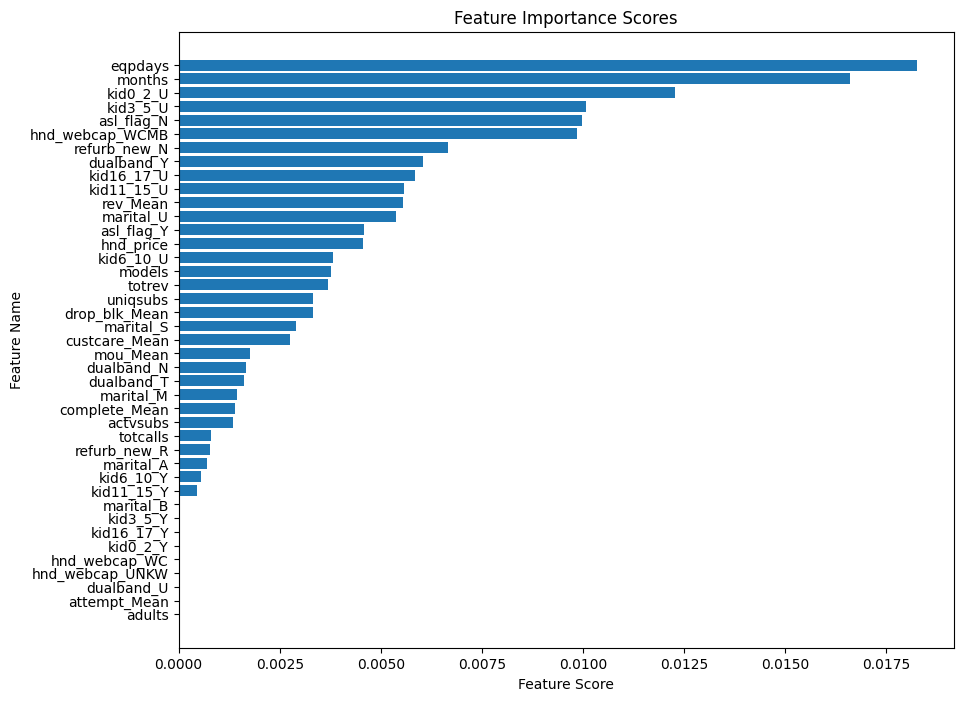

In [177]:
scores = fs.scores_
feature_names = fs.get_feature_names_out()
sorted_scores, sorted_feature_names = zip(*sorted(zip(scores, feature_names), reverse=False))

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, (sorted_scores))
plt.xlabel('Feature Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores')

In [180]:
rfc_fs = RandomForestClassifier()

rfc_fs.fit(X_train_fs, y_train)
rfc_fs.score(X_test_fs, y_test)

0.59645

In [181]:
y_pred_fs = rfc_fs.predict(X_test_fs)
print(classification_report(y_test, y_pred_fs))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     10088
           1       0.59      0.59      0.59      9912

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



In [78]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
#rfc.score(X_test, y_test)

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     10088
           1       0.59      0.60      0.59      9912

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



In [182]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV()

clf.fit(X_train_fs, y_train)
clf.score(X_test_fs, y_test)

y_pred_ts_log = clf.predict(X_test_fs)
print(classification_report(y_test, y_pred_ts_log))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10088
           1       0.57      0.54      0.56      9912

    accuracy                           0.57     20000
   macro avg       0.57      0.57      0.57     20000
weighted avg       0.57      0.57      0.57     20000



In [196]:
rfc = RandomForestClassifier()
rfe = RFECV(estimator=rfc, step=4, cv=5, min_features_to_select=10, scoring='accuracy', verbose=2)
# rfe = RFE(rfc, step=2, verbose=2)
fit = rfe.fit(X_train, y_train)

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 fe

Text(0.5, 1.0, 'Feature Importance Scores')

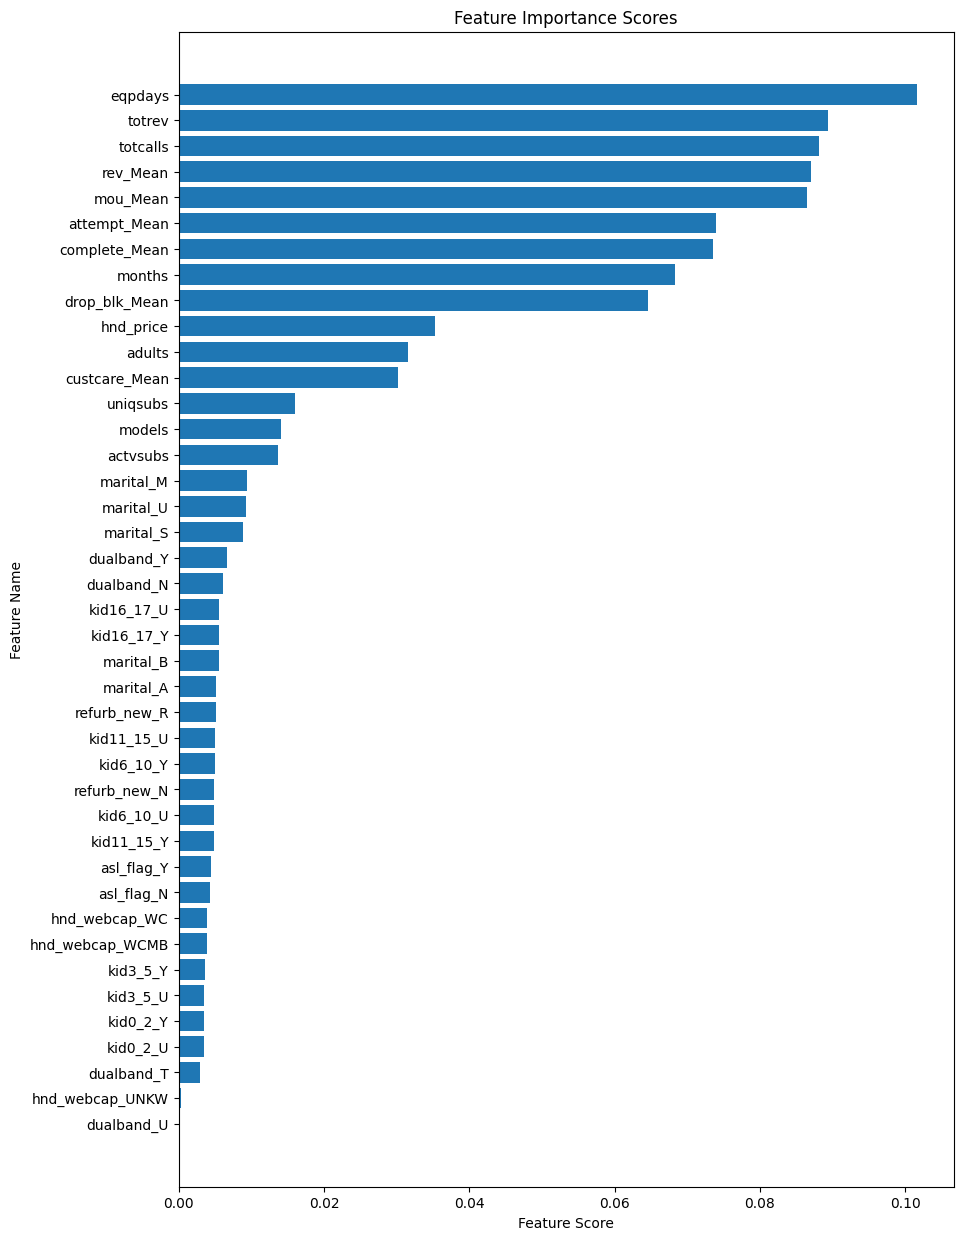

In [197]:
scores = fit.estimator_.feature_importances_
feature_names = fit.get_feature_names_out()
sorted_scores, sorted_feature_names = zip(*sorted(zip(scores, feature_names), reverse=False))

# Create a horizontal bar plot
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_scores)
plt.xlabel('Feature Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores')



In [224]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

rfc_rfe = RandomForestClassifier()
rfc_rfe.fit(X_train_rfe, y_train)
rfc_rfe.score(X_test_rfe, y_test)

y_pred = rfc_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     10088
           1       0.58      0.58      0.58      9912

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000



In [191]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

xgb_classifier = xgb.XGBClassifier()

cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Training the model on the entire training set
xgb_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Cross-validation scores: [0.6013125 0.60475   0.60525   0.605125  0.6015625]
Mean CV accuracy: 0.6036
Test accuracy: 0.5902


In [192]:
lgb_classifier = LGBMClassifier(learning_rate= 0.05, 
                    max_depth= 12, 
                    n_estimators= 1000, 
                    subsample= 0.1)



# Cross-validation
cv_scores = cross_val_score(lgb_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Training the model on the entire training set
lgb_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred = lgb_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 31720, number of negative: 32280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495625 -> initscore=-0.017500
[LightGBM] [Info] Start training from score -0.017500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you d

In [193]:
from sklearn.model_selection import KFold

lgb = LGBMClassifier(learning_rate= 0.05, 
                    max_depth= 12, 
                    n_estimators= 1000, 
                    subsample= 0.1)

rfecv = RFECV(estimator=lgb, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='accuracy', verbose=2)

rfecv.fit(X_train.loc[:3000,:], y_train.loc[:3000])

Fitting estimator with 41 features.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 30893, number of negative: 31479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2010
[LightGBM] [Info] Number of data points in the train set: 62372, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495302 -> initscore=-0.018791
[LightGBM] [Info] Start training from score -0.018791
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fitting estimato

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(learning_rate=0.05, max_depth=12,
                               n_estimators=1000, subsample=0.1),
      scoring='accuracy', step=10, verbose=2)

In [194]:
cols_lg = X_train.columns[rfecv.ranking_==1].to_list()
X_train_lg = X_train[cols_lg]
X_test_lg = X_test[cols_lg]

fit_lgb = lgb.fit(X_train_lg, y_train)

fit_lgb.score(X_test_lg, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 39650, number of negative: 40350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1970
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495625 -> initscore=-0.017500
[LightGBM] [Info] Start training from score -0.017500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.6072

Text(0.5, 1.0, 'Feature Importance Scores')

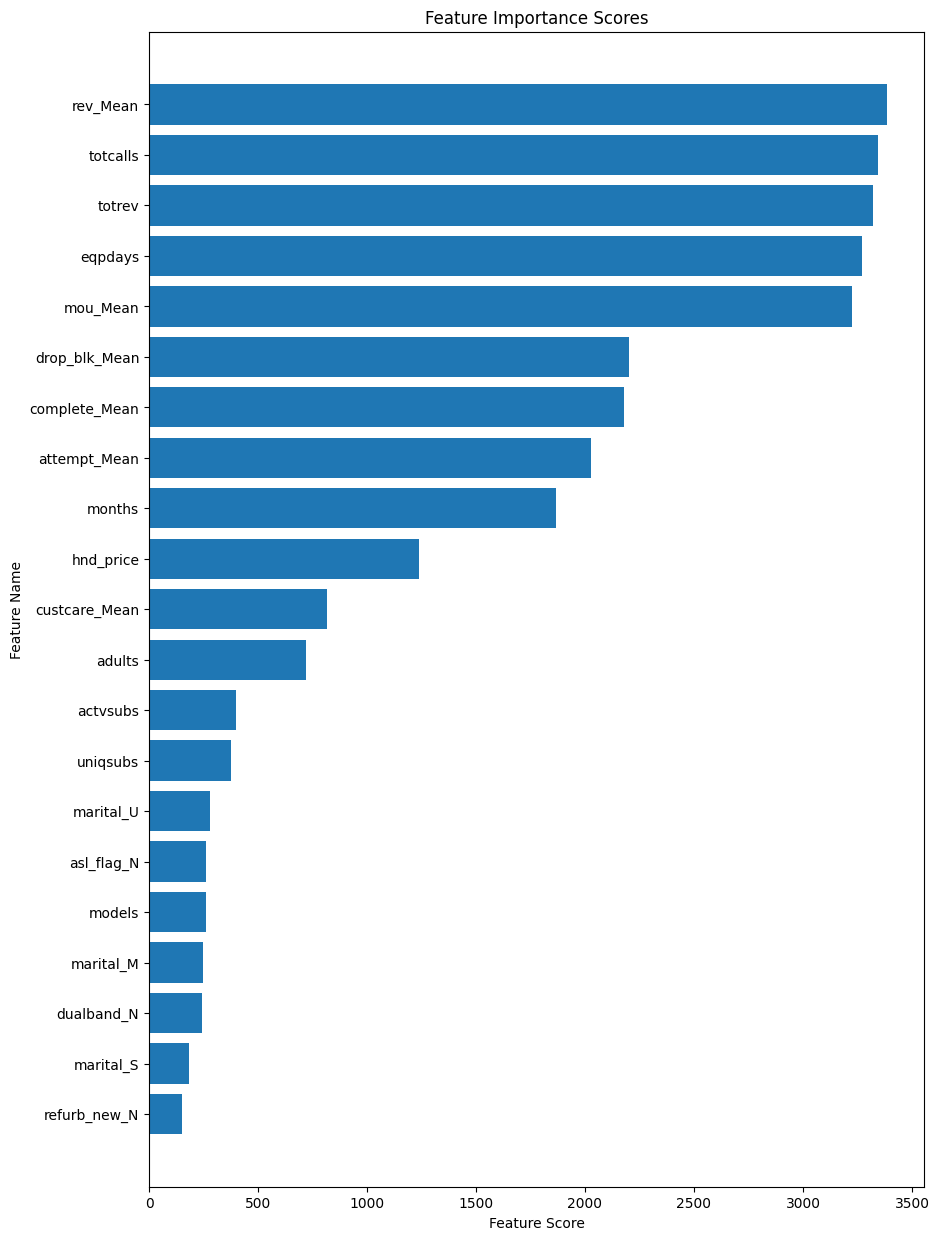

In [195]:
scores = fit_lgb.feature_importances_
feature_names = fit_lgb.feature_name_
sorted_scores, sorted_feature_names = zip(*sorted(zip(scores, feature_names), reverse=False))

# Create a horizontal bar plot
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_scores)
plt.xlabel('Feature Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance Scores')

